# Introduction to Bayesian Statistics 

Yi-Chi Liao (yi-chi.liao@aalto.fi) 

PhD student in User Interfaces group.

## Outline of the lecture<a id="outline">

<div class="alert alert-block alert-success">
<h2><img src="../images/goal.png" width=20, align="left">&nbsp;After the lecture, you should know...</h2>
    <ul>
        <li>Frequentists vs Bayesians (<a href="#0">Part 0</a>):
            <ul>
              <li><a href="#01">what is probability</a></li>
              <li><a href="#02">frequentist stats analysis</a></li>
              <li><a href="#03">Bayesian stats analysis</a></li>
              <li><a href="#04">basic concept of data generation</a></li>
            </ul>
            <br>
        <li>Generating data using probability (<a href="#1">Part 1</a>):
            <ul>
              <li><a href="#11">simulating data with uniform distribution</a></li>
              <li><a href="#12">binomial distibution</a></li>
              <li><a href="#13">ECDFs</a></li>
              <li><a href="#14">Poison distribution</a></li>
              <li><a href="#15">exponential distribution</a></li>
              <li><a href="#16">normal distribution</a></li>
            </ul>
            <br>
        <li>Bayes' Theorem and Bayesian inference (<a href="#2">Part 2</a>)
            <ul>
              <li><a href="#21">conditional and joint probability</a></li>
              <li><a href="#22">Bayes' Theorem</a></li>
              <li><a href="#23">Bayesian Inference</a></li>
            </ul>
            <br>
        <li>Bayesian stastistics (<a href="#3">Part 3</a>)
            <ul>
              <li><a href="#31">basic steps of Bayesian stats analysis</a></li>
              <li><a href="#32">Parameter estimation</a></li>
              <li><a href="#33">comparing A/B group</a></li>
            </ul>
            <br>
        <li><a href="#summary">Summary</a>
    </ul>
</div>


In [1]:
#Import
import pymc3 as pm
import arviz as az
import numpy as np
import numpy.random as npr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import binom
import scipy.stats as st
from empiricaldist import Pmf
from collections import Counter
from ipywidgets import interact
import matplotlib as mpl

%matplotlib inline
sns.set()
sns.set_style('white')
sns.set_context('talk')
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

# Part 0: Frequentist vs Bayesian<a id="0">

<div class="alert alert-block alert-success">
<h2><img src="../images/goal.png" width=20, align="left">&nbsp;Learning objectives of part 0</h2>
    <br>Learn to:
    <ul>
        <li>know the foundamental difference between frequentists' and Bayesians' view of probability
        <li>know the credibility region of Bayesian probability
    </ul>
</div>


## 0.1 Probability<a id="01">

Discussion: What is probability?

> Bayesian inference differs from more traditional statistical inference by preserving *uncertainty*. At first, this sounds like a bad statistical technique. Isn't statistics all about deriving *certainty* from randomness? To reconcile this, we need to start thinking like Bayesians. 

> The Bayesian world-view interprets probability as measure of *believability in an event*, that is, how confident we are in an event occurring. In fact, we will see in a moment that this is the natural interpretation of probability. 

> For this to be clearer, we consider an alternative interpretation of probability: *Frequentist*, known as the more *classical* version of statistics, assumes that probability is the long-run frequency of events (hence the bestowed title). For example, the *probability of plane accidents* under a frequentist philosophy is interpreted as the *long-term frequency of plane accidents*. This makes logical sense for many probabilities of events, but becomes more difficult to understand when events have no long-term frequency of occurrences. Consider: we often assign probabilities to outcomes of presidential elections, but the election itself only happens once! Frequentists get around this by invoking alternative realities and saying across all these realities, the frequency of occurrences defines the probability. 

> Bayesians, on the other hand, have a more intuitive approach. Bayesians interpret a probability as measure of *belief*, or confidence, of an event occurring. Simply, a probability is a summary of an opinion. An individual who assigns a belief of 0 to an event has no confidence that the event will occur; conversely, assigning a belief of 1 implies that the individual is absolutely certain of an event occurring. Beliefs between 0 and 1 allow for weightings of other outcomes. This definition agrees with the probability of a plane accident example, for having observed the frequency of plane accidents, an individual's belief should be equal to that frequency, excluding any outside information. Similarly, under this definition of probability being equal to beliefs, it is meaningful to speak about probabilities (beliefs) of presidential election outcomes: how confident are you candidate *A* will win?


-- _Probabilistic Programming and Bayesian Methods for Hackers_

Discussion: If you throw a coin 20 times, and get 15 heads, will you call it a fair coin?  
Given another known fair coin, how will design an experiment to justify the previous observation?

## 0.2 Frequentist statistical analysis and p-value<a id="02">

Frequentists' solution: Assume the skeptic is correct (this is a fair point that has 0.5 chance produce head), what is the probability (long-run frequency of this event) of having 15 or more heads simply by chance?

Flip the coin once, the chance of having a head is:  
$p(H) = \frac{1}{2} $  

Flip the coin twice, the chance of having two head is:  
$p(HH) = \frac{1}{2} \times \frac{1}{2}$  

And so on...   
$p(HHT) = \frac{1}{2} \times \frac{1}{2} \times \frac{1}{2} = \frac{1}{8}$    

If we don't care about the order of appearance:  
$p(2H, 1T) = p(HHT) + p (HTH) + p (THH)= 3 \times \frac{1}{2} \times \frac{1}{2} \times \frac{1}{2} = \frac{3}{8}$   

This is known as the binomial distribution:  
$p (N_H, N_T) ={{N}\choose{N_H}}(\frac{1}{2})^{N_H}(1 - \frac{1}{2})^{N_T}$

The probability of having >=  15 times of heads is (p-value)  0.020493507385253823


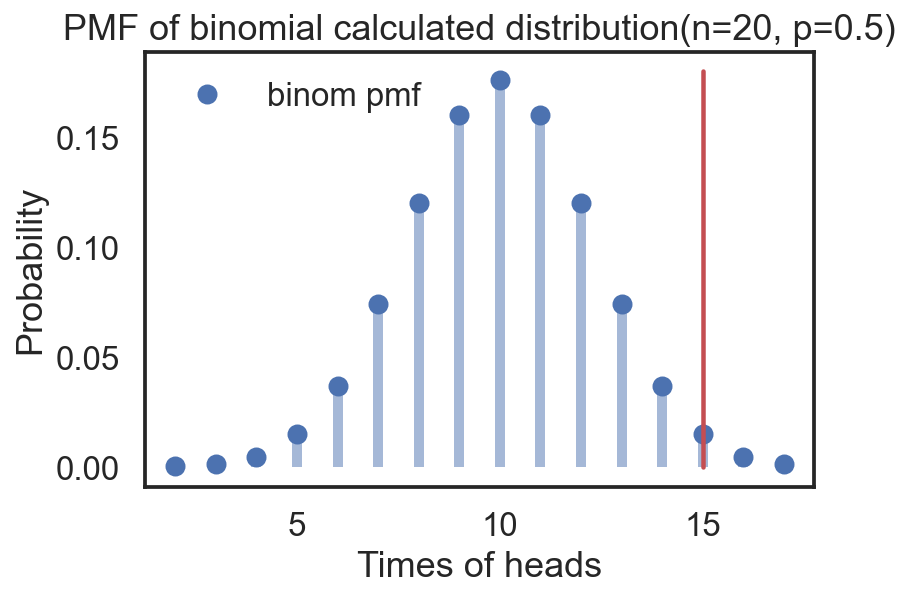

In [2]:
def binom_pmf(n=1, p=0.1, head_times=1):

    binom_dis = binom(n, p)  ## A function imported from Scipy
    x = np.arange(binom_dis.ppf(0.0001), binom_dis.ppf(0.9999))
    binom_p = binom_dis.pmf(x)  
    idx = 0
    prob_more_than_t = 0
    if (head_times in x):
        idx = np.where(x==head_times)[0][0]
        prob_more_than_t = np.sum(binom_p[idx:])
        print ("The probability of having >= ", head_times, "times of heads is (p-value) ",prob_more_than_t)
    fig, ax = plt.subplots(1, 1)
    ax.plot(x, binom_dis.pmf(x), 'bo', c='b',label='binom pmf')
    ax.vlines(x, 0, binom_dis.pmf(x), colors='b', lw=5, alpha=0.5)
    ax.legend(loc='best', frameon=False)
    ax.plot([head_times,head_times],[0,0.18],c='r')
    plt.ylabel('Probability')
    plt.xlabel('Times of heads')
    plt.title('PMF of binomial calculated distribution(n={}, p={})'.format(n, p))
    plt.show()

binom_pmf(n=20, p=0.5,head_times =15) 

Probability of 0.02 (2%) of observations given a fair coin **(one-tail)**.  
Conclusion: we can reject the null hypothesis (this is a fair coin) at p < 0.05.

Frequentists analyze the p-values as such: If the experiment is repeated many times, how many cases the computed confidence interval will contain the the current or even more extreme event.

**Side note:**   
PMF = Probability Mass Function (gives the probability that a discrete random variable is exactly equal to some value.)   
PDF = Probability Density Function (specifies the probability of the random variable falling within a particular range of values, as opposed to taking on any one value.)

### Hands-on 
What is the probability of having >= 12 heads given 20 coin flips? Can you reject the null hypothesis?  
What is the probability of having >= 25 heads given 40 coin flips? Can you reject the null hypothesis now?  

<a href="#coin_data_gen">Jump to simulation</a>

### Let's see this from a more general view:
In general, a frequentist 95% Confidence Intervals is not any particular interval has 95% likelihood (or confidence, or belief) to contain the true value!

If you think that, **you're actually a Bayesian!**

![frequentist0](../images/frequentist0.png)

It actually means that **95% of the samples in repeated experiments will form such intervals that contain the true value**.  

If p-value < 0.05, that means given the ture value, there are only less than 5% of such samples contain our particular observation (frequency of heads) or even more extreme cases.
![frequtist](../images/frequentist4.png)


![jackie](../images/jackie.jpg)

### A typical conversation:

Statistician: "95% of such confidence intervals in repeated measurments will contain the true value."  
Scientist/Engineer: "So there is 95% of chance that the value is in the interval."  

Statistician: "No, you see, parameters (true values) by definition can't vary, so referring to chance in that context is meaningless. The 95% chance refers to the confidence interval itself."  
Scientist/Engineer: "Oh! So there is 95% of chance that the value is in the interval?"   

Statistician: "No. It's like this: the long-term limiting frequency of the procedure of constructing this interval ensures that 95% of the resulting ensemble of intervals will contain the value."  
Scientist/Engineer: "Ah! I see! So there is 95% of chance that the value is in the interval, right?"   

Statistician: "No... It's that... Well... just write down what I said, okay?"  
Scientist/Engineer: "Ok! Got it! The true value is 95% likely to be in the interval." 

If you still have questions, it's highly recommended to view this excellent blog artical: [frequentist vs Bayesian](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)   

### Limitations of Frequentists' view

0. (Unintuitive way of seeing probability)
1. The setting of p-value and number of samples are problematic in practice.
2. It can only tell if there is a difference, or an effect. There is no information when the outcome is insignificant.
3. It does not provide the model based on our current obsevations. For example, given the observations of 15 heads and 5 tails, it does not tell you the probability of 14 heads and 6 tails if you flip the coin another 20 times.
4. You need to use various methods for different tests!


## 0.3 Bayesian statistical analysis and credibility region<a id="03">


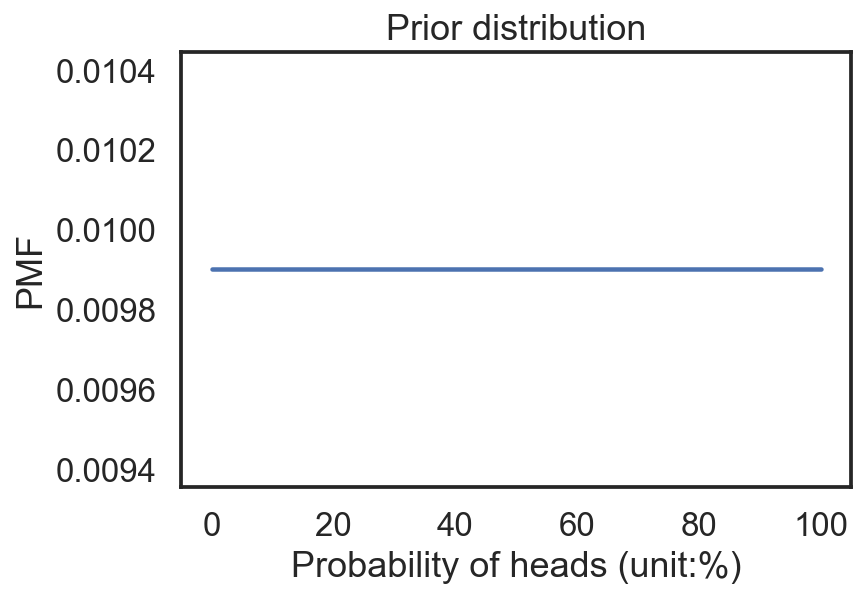

In [3]:
def likelihood_euro(data, hypo):
    x = hypo / 100
    if data == 'H':
        return x
    else:
        return 1-x

def decorate_euro(title):
    plt.xlabel('Probability of heads (unit:%)')
    plt.ylabel('PMF')
    plt.title(title)

euro = Pmf.from_seq(range(101))
euro.plot()
decorate_euro('Prior distribution')

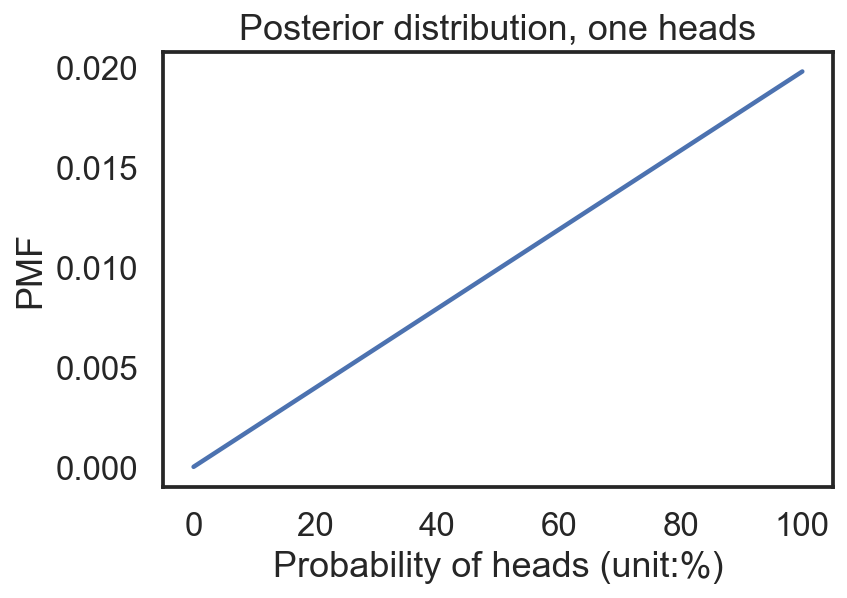

In [4]:
euro.update(likelihood_euro, 'H')
euro.plot()
decorate_euro('Posterior distribution, one heads')

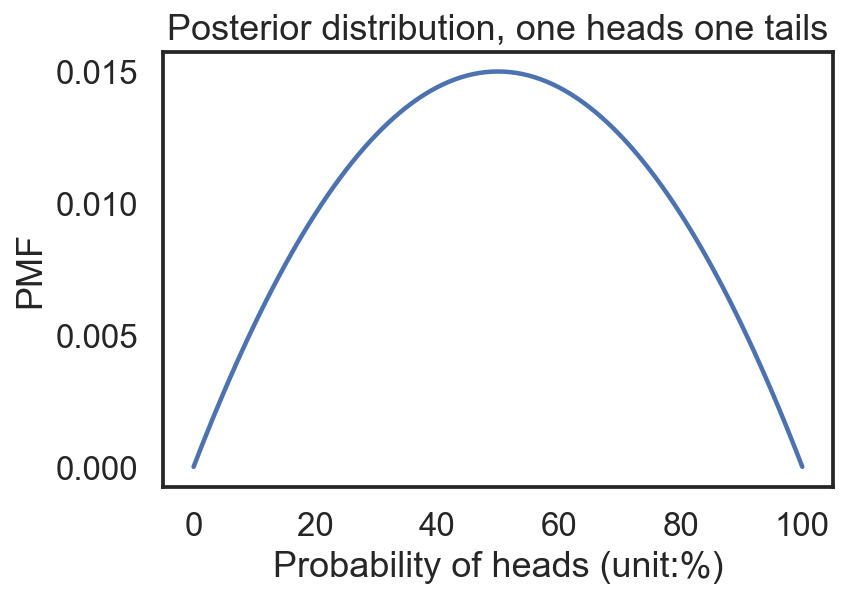

In [5]:
euro.update(likelihood_euro, 'T')
euro.plot()
decorate_euro('Posterior distribution, one heads one tails')

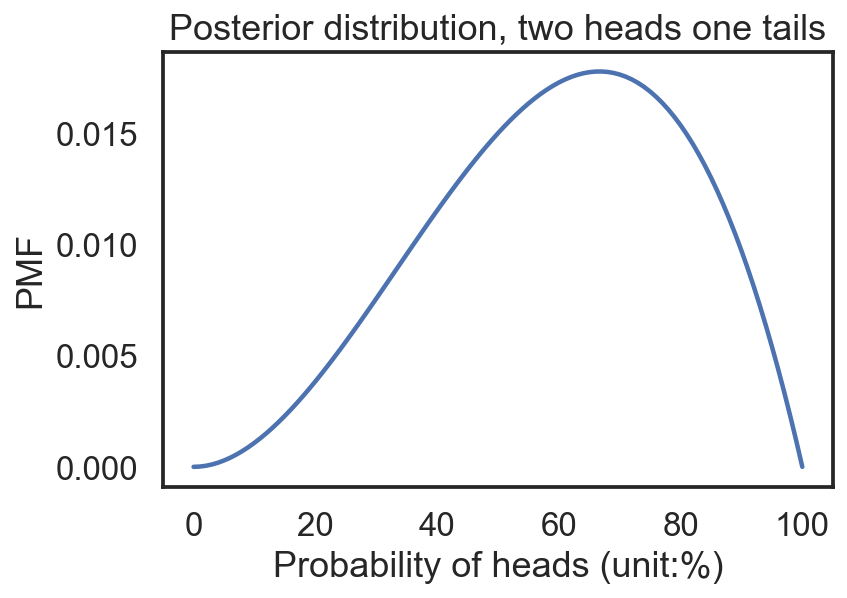

In [6]:
euro.update(likelihood_euro, 'H')
euro.plot()
decorate_euro('Posterior distribution, two heads one tails')

The 95% credibility interval is from  53.0 % to  89.0 %.


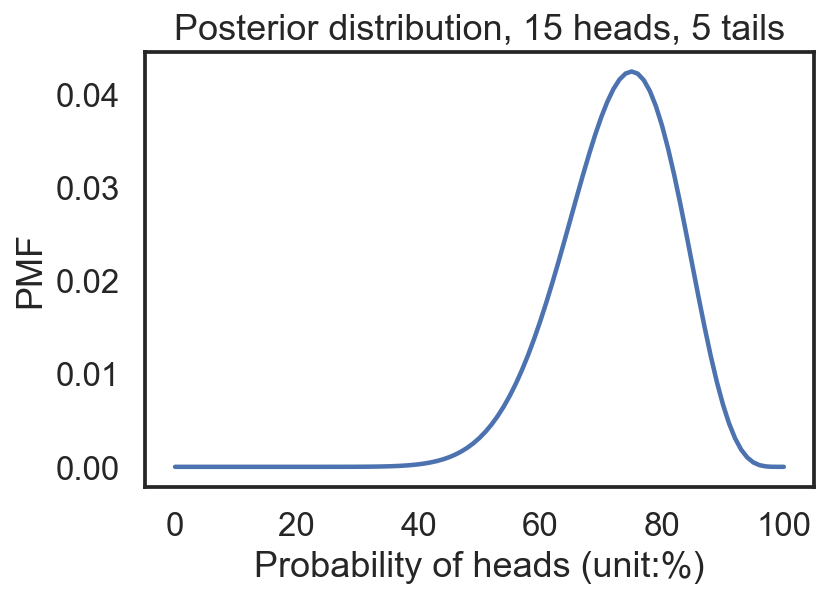

In [7]:
euro = Pmf.from_seq(range(101))
head_times = 15
tail_times = 5
evidence = 'H' * head_times + 'T' * tail_times
for outcome in evidence:
    euro.update(likelihood_euro, outcome)
    
euro.plot()
decorate_euro('Posterior distribution, '+str(head_times) +' heads, ' + str(tail_times)+ ' tails')
cred_interval = euro.credible_interval(0.95)
print ("The 95% credibility interval is from ", cred_interval[0], "% to ", cred_interval[1], "%.")

### Hands-on 
What is the distribution if you observe 13 heads and 7 tails? Is 50% within the credibility interval now?  
What is the distribution if you observe 26 heads and 14 tails? 

Bayesians' view: We can create a model (distribution of belief) based on the observations, then check if our hypothesis is in the credibility region.

![bayesian](../images/bayesian3.png)

### Advantages of Bayesians probability
1. Bayesian provides a more natural interpretation of the data.
2. Bayesian provides an informative model based on the current samples.
3. It does not simply tell you if there is an effect, but also tell you how strong the effect is.
4. Bayesian analysis draws more reasonable conclusions from small-sample studies.
5. There is only one method -- simulation and inference -- in Bayesian analysis, while traditional statistics has A LOT OF methods for different scenarios.

### Application of Bayesian probability

1. Probabilistic modelling and simulation  
2. Bayesian inference
3. Bayesian stastistics
4. Gaussian Process and Bayesian Optimization (not covered today)

## 0.4 Coin-flipping with data generation<a id="04">

The probability of having >=  15 times of heads is  0.0


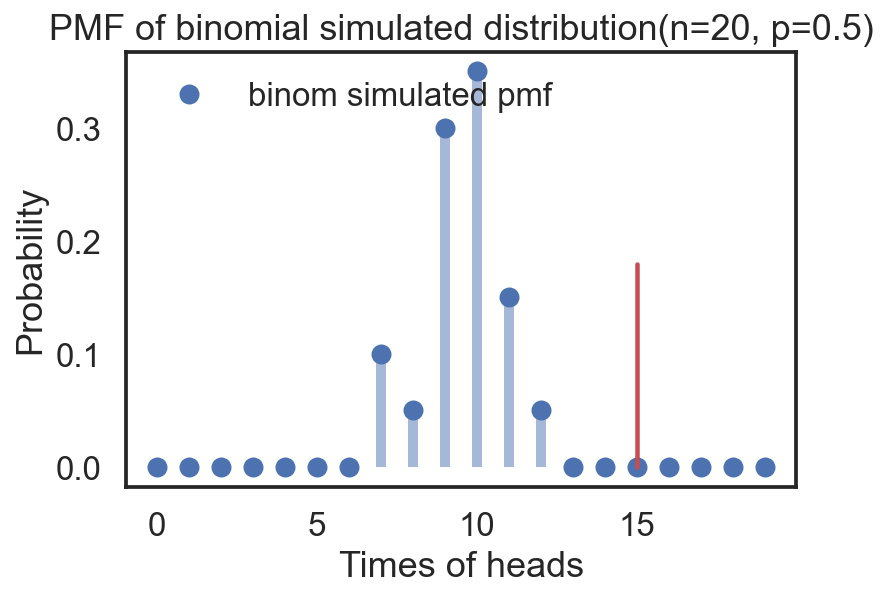

In [8]:
def binom_simulation(n=1, p=0.1, sample=10000, head_times=1):
    binom_data = np.random.binomial(n, p, size=sample)
    bino_s_distribution = np.zeros((n))
    for i in range(len(bino_s_distribution)):
        bino_s_distribution[i] = np.count_nonzero(binom_data ==i)/sample
    
    x = np.arange(n)
    prob_more_than_t = np.sum(bino_s_distribution[head_times:])
    print ("The probability of having >= ", head_times, "times of heads is ", round(prob_more_than_t,8))
    fig, ax = plt.subplots(1, 1)
    ax.plot(x, bino_s_distribution, 'bo', c='b',label='binom simulated pmf')
    ax.vlines(x, 0,bino_s_distribution, colors='b', lw=5, alpha=0.5)
    ax.legend(loc='upper left', frameon=False)
    ax.plot([head_times,head_times],[0,0.18],c='r')
    plt.ylabel('Probability')
    plt.xlabel('Times of heads')
    plt.title('PMF of binomial simulated distribution(n={}, p={})'.format(n, p))
    plt.show()

binom_simulation(n=20, p=0.5,sample=20,head_times =15) 

Is the distribution same as the calculated binomial distribution? Why not?

### Hands-on <a id="coin_data_gen"> 
- What is the probability if you give it 100 samples? 
- What is the probability given 1,000,000 samples? 

The probability of having >=  15 times of heads is (p-value)  0.020493507385253823


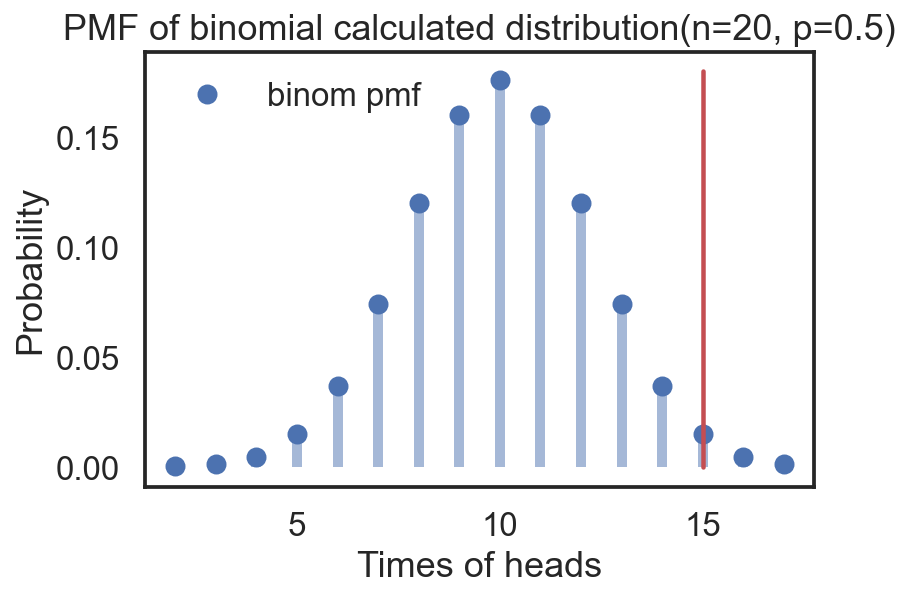

In [9]:
binom_pmf(n=20, p=0.5,head_times =15) 

<a href="#outline">Going back to outline</a>

----

# Part 1: Probability Simulation<a id="1">

<div class="alert alert-block alert-success">
<h2><img src="../images/goal.png" width=20, align="left">&nbsp;Learning objectives of part 1</h2>
    <br>Learn to:
    <ul>
        <li>understand of what "probability" means, in both Bayesian and Frequentist terms
        <li>simulate probability distributions that model real-world phenomena
        <li>have a basic idea of classic distributions
    </ul>
</div>


## 1.1 Simulating probabilities<a id="11">

* Let's say 50% of the Aalto students have iPhone. If we picked 1000 people at random from the population, how likely would it be to find that a certain number of them having iPhone?

We can simulate this using `numpy`'s random number generator.

To do so, first note we can use `np.random.rand()` to randomly select floats between 0 and 1 (known as the _uniform distribution_). Below, we do so and plot a histogram:

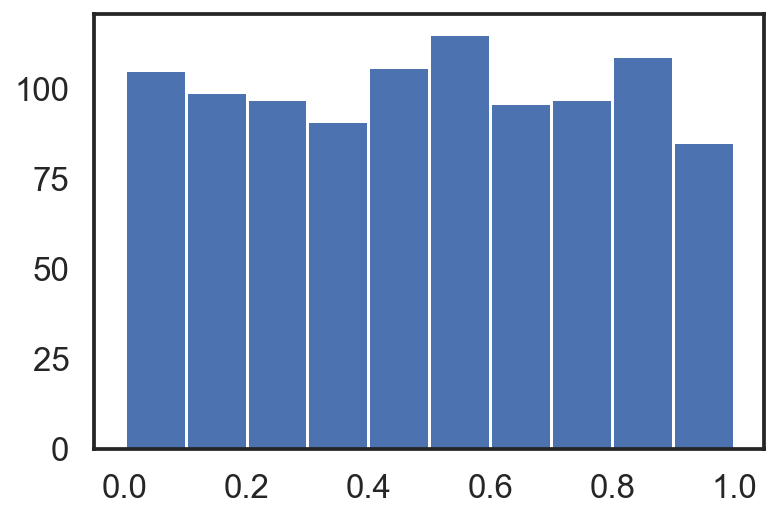

In [10]:
# Draw 1,000 samples from uniform & plot results
x = np.random.rand(1000)
plt.hist(x);

To then simulate the sampling from the population, we check whether each float was greater or less than 0.5. If less than or equal to 0.5, we say the person has an iPhone.

In [11]:
# Computed how many people click
iphone = x <= 0.5
n_iphone = sum(iphone)
f"Number of iphone = {n_iphone}"

'Number of iphone = 498'

The proportion of people who own iphone can be calculated as such:

In [12]:
# Computed proportion of people with an iphone
f"Proportion who owns iphone = {n_iphone/len(iphone)}"

'Proportion who owns iphone = 0.498'

**Discussion**: Did you get the same answer as your neighbor? If you did, why? If not, why not?

**Up for discussion:** Let's say that all you had was this data and you wanted to figure out the iPhone rate (probability of a student in Aalto has iPhone). 

* What would your estimate be?

**Note:** Although, in the above, we have described _probability_ in two ways, we have not described it mathematically. We're not going to do so rigorously here, but we will say that _probability_ defines a function from the space of confidence (in the above, the interval $[0,1]$) that describes how likely it is to get a particular point or region in that space. Mike Betancourt has an elegant [Introduction to Probability Theory (For Scientists and Engineers)](https://betanalpha.github.io/assets/case_studies/probability_theory.html) that I can recommend.

### Hands-on: iPhone example

Use random sampling to simulate how many people have iPhone when the iPhone rate is 0.7. How many people in total? What proportion?

In [13]:
# Solution
iphone = x <= 0.7
n_iphone = sum(iphone)
print(f"Number of iphone = {n_iphone}")
print(f"Proportion who owns iphone = {n_iphone/len(iphone)}")

Number of iphone = 710
Proportion who owns iphone = 0.71


_Discussion point_: This model is known as the bias coin flip. 
- Can you see why?

### Perofrmance of a 3D pointing task in virtual reality

You can also calculate such proportions with real-world data. Here we import a dataset of 3D pointing experiment that was collected in our recently submission.



![selection](../images/app-3dtouch-device.png)

In [14]:
# Import and view head of data
df_12 = pd.read_csv('../data/user1_raw_log.csv')
df_12.head()

completion_time  spatial_errors  target_distance
0           1680.0           13.27                2
1           1660.0            5.69                2
2           1100.0            0.04                1
3           1220.0            4.21                1
4           1840.0            2.21                3

In [15]:
c_time = df_12['completion_time']

* What is the proportion of completion time  > 1200 ?

In [16]:
p = (sum(c_time > 1200))/len(c_time)
p

0.36672850958565245

### Proportion: A proxy for probability

As stated above, we have calculated a frequency as probability. As a proxy for the probability, we can further simulate drawing random samples (with replacement) from the data seeing how many trials have completion time are > 1200 and calculating the proportion (commonly referred to as [hacker statistics](https://speakerdeck.com/jakevdp/statistics-for-hackers)):

In [17]:
n_samples = 10000
sum(np.random.choice(c_time, n_samples, replace=True) > 1200)/n_samples

0.3666

### Remember

We just experienced a simple example that we built an extremely simple probabilistic model with a small dataset. The probabilistic model essntially is a function describes how likely it is to get a particular point or region in a defined space. Upon this model, we then generated a bunch of simulated data.

## 1.2 Another way to simulate coin-flips (Binomial distribution)<a id="12">

In the above, you have used the uniform distribution to sample from a series of biased coin flips. I want to introduce you to another distribution that you can also use to do so: the **binomial distribution**.

The **binomial distribution** with parameters $n$ and $p$ is defined as the probability distribution of

> the **number of heads seen** when flipping a coin $n$ times when  with $p(heads)=p$.

**Note** that this distribution essentially tells the **story** of a general model in the following sense: if we believe that they underlying process generating the observed data has a binary outcome (affected by disease or not, head or not, 0 or 1, clicked through or not), and that one the of the two outcomes occurs with probability $p$, then the probability of seeing a particular outcome is given by the **binomial distribution** with parameters $n$ and $p$.

Any process that matches the coin flip story is a Binomial process (note that you'll see such coin flips also referred to as Bernoulli trials in the literature).  So we can also formulate the story of the Binomial distribution as

> the number $r$ of successes in $n$ Bernoulli trials with probability $p$ of success, is Binomially distributed. 

We'll now use the binomial distribution to answer the same question as above:
* If P(heads) = 0.7 and you flip the coin ten times, how many heads will come up?

We'll also set the seed to ensure reproducible results.

In [18]:
# Set seed
np.random.seed(seed=16071982)

# Simulate one run of flipping the biased coin 10 times
np.random.binomial(10, 0.7)

7

### Simulating many times to get the distribution

In the above, we have simulated the scenario once. But this only tells us one potential outcome. To see how likely it is to get $n$ heads, for example, we need to simulate it a lot of times and check what proportion ended up with $n$ heads.

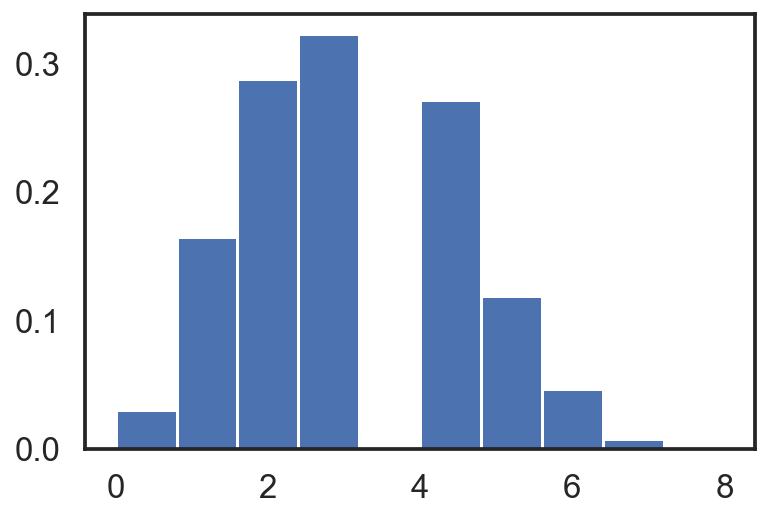

In [19]:
# Simulate 1,000 run of flipping the biased coin 10 times
x = np.random.binomial(10, 0.3, 1000)

# Plot normalized histogram of results
plt.hist(x, density=True, bins=10);

* Group chat: what do you see in the above?

### Hands-on: Probabilities

- If I flip a biased coin ($P(H)=0.3$) 20 times, what is the probability of 5 or more heads?

In [20]:
# Solution
sum(np.random.binomial(20, 0.3, 10000) >= 5)/10000

0.759

- If I flip a fair coin 20 times, what is the probability of 5 or more heads?

In [21]:
sum(np.random.binomial(20,0.5,10000) >= 5)/10000

0.993

- Plot the normalized histogram of number of heads of the following experiment: flipping a fair coin 10 times.

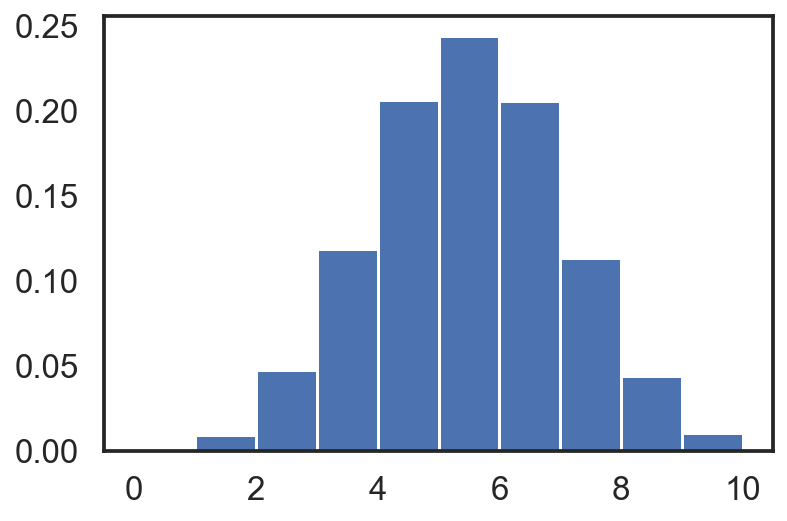

In [22]:
# Plot histogram 
x = np.random.binomial(10, 0.5, 10000)
plt.hist(x, density=True, bins=10);

**Note:** you may have noticed that the _binomial distribution_ can take on only  a finite number of values, whereas the _uniform distribution_ above can take on any number between $0$ and $1$. These are different enough cases to warrant special mention of this & two different names: the former is called a _probability mass function_ (PMF) and the latter a _probability distribution function_ (PDF). 


**Discussion:** What is the probability of having more than 4 heads? Can you easily tell that from a histogram plot?

## 1.3 Empirical cumulative distribution functions (ECDFs)<a id="13">

An ECDF is, as an alternative to a histogram, a way to visualize univariate data that is rich in information. It allows you to visualize all of your data and, by doing so, avoids the very real problem of binning.
- can plot control plus experiment
- data plus model!
- many populations
- can see multimodality (though less pronounced) -- a mode becomes a point of inflexion!
- can read off so much: e.g. percentiles.

See Eric Ma's post on ECDFS [here](https://ericmjl.github.io/blog/2018/7/14/ecdfs/) AND [this twitter thread](https://twitter.com/allendowney/status/1019171696572583936).

So what is  this ECDF? 

**Definition:** In an ECDF, the x-axis is the range of possible values for the data & for any given x-value, the corresponding y-value is the proportion of data points less than or equal to that x-value.

Let's define a handy ECDF function that takes in data and outputs $x$ and $y$ data for the ECDF.

In [23]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points
    n = len(data)

    # x-data for the ECDF
    x = np.sort(data)

    # y-data for the ECDF
    y = np.arange(1, n+1) / n

    return x, y

### Hands-on: Plotting ECDFs

Plot the ECDF for the previous hands-on  exercise. Read the answer to the following question off the ECDF: he probability of seeing 4 or more heads?

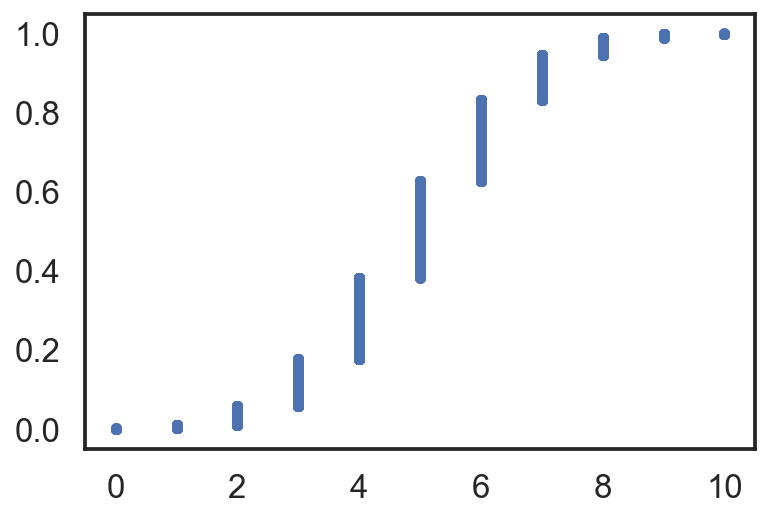

In [24]:
# Generate x- and y-data for the ECDF
x_flips, y_flips = ecdf(x)

# Plot the ECDF
plt.plot(x_flips, y_flips, marker='.', linestyle='none');

### Probability distributions and their stories

In the above, we saw that we could match data-generating processes with binary outcomes to the story of the binomial distribution.

> The Binomial distribution's story is as follows: the number $r$ of successes in $n$ Bernoulli trials with probability $p$ of success, is Binomially distributed. 

There are many other distributions with stories also!

## 1.4 Poisson processes and the Poisson distribution<a id="14">

In the book [Information Theory, Inference and Learning Algorithms](https://www.amazon.com/Information-Theory-Inference-Learning-Algorithms/dp/0521642981) David MacKay tells the tale of a town called Poissonville, in which the buses have an odd schedule. Standing at a bus stop in Poissonville, the amount of time you have to wait for a bus is totally independent of when the previous bus arrived. This means you could watch a bus drive off and another arrive almost instantaneously, or you could be waiting for hours.

Arrival of buses in Poissonville is what we call a Poisson process. The timing of the next event is completely independent of when the previous event happened. Many real-life processes behave in this way. 

* natural births in a given hospital (there is a well-defined average number of natural births per year, and the timing of one birth is independent of the timing of the previous one);
* Landings on a website;
* Meteor strikes;
* Molecular collisions in a gas;
* Aviation incidents.

Any process that matches the buses in Poissonville **story** is a Poisson process.

    

The number of arrivals of a Poisson process in a given amount of time is Poisson distributed. The Poisson distribution has one parameter, the average number of arrivals in a given length of time. So, to match the story, we could consider the number of hits on a website in an hour with an average of six hits per hour. This is Poisson distributed.

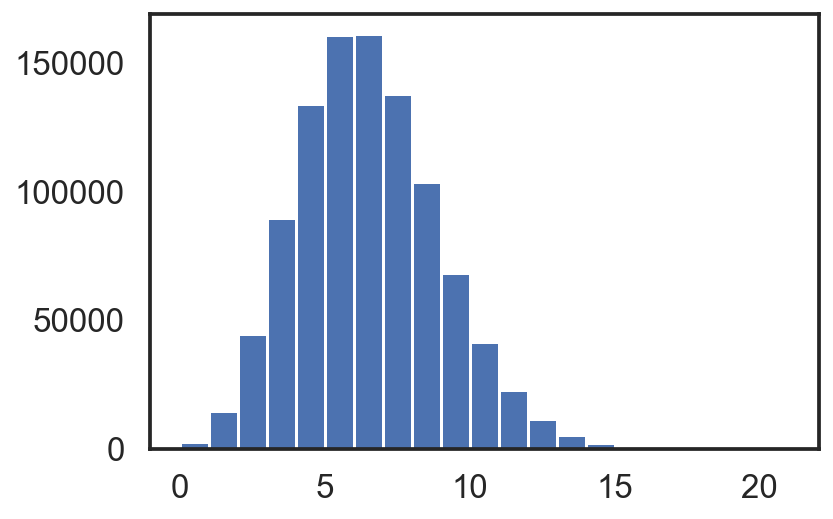

In [25]:
# Generate Poisson-distributed data
samples  =  np.random.poisson(6, size=10**6)

# Plot histogram
plt.hist(samples, bins=21);

**Question:** Does this look like anything to you?

In fact, the Poisson distribution is the limit of the Binomial distribution for low probability of success and large number of trials, that is, for rare events. 

To see this, think about the stories. Picture this: you're doing a Bernoulli trial once a  minute for an hour, each with a success probability of 0.05. We would do 60 trials, and the number of successes is Binomially distributed, and we would expect to get about 3 successes. This is just like the Poisson story of seeing 3 buses on average arrive in a given interval of time. Thus the Poisson distribution with arrival rate equal to np approximates a Binomial distribution for n Bernoulli trials with probability p of success (with n large and p small). This is useful because the Poisson distribution can be simpler to work with as it has only one parameter instead of two for the Binomial distribution.

#### Hands-on: Poisson

Plot the ECDF of the Poisson-distributed data that you generated above.

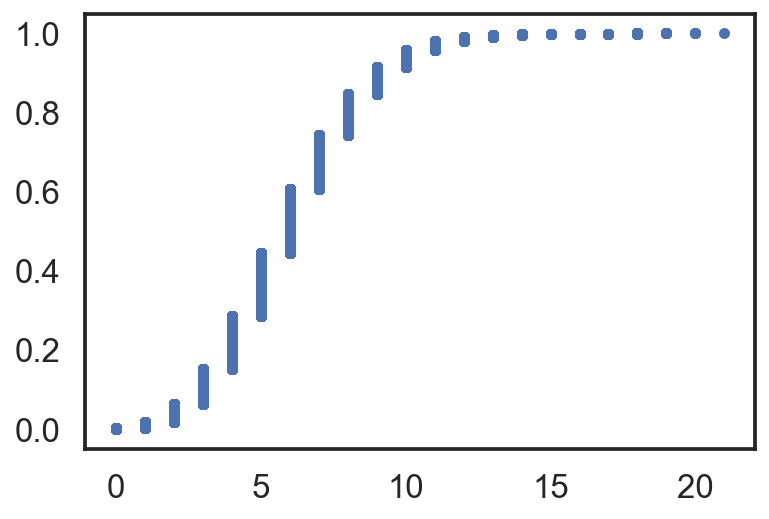

In [26]:
# Generate x- and y-data for the ECDF
x_p, y_p = ecdf(samples)

# Plot the ECDF
plt.plot(x_p, y_p, marker='.', linestyle='none');

#### Example Poisson distribution: field goals attempted per game

Let's first remind ourselves of the story behind the Poisson distribution.
> The number of arrivals of a Poisson processes in a given set time interval is Poisson distributed.

We could model field goal attempts in a basketball game using a Poisson distribution. When a player takes a shot is a largely stochastic process, being influenced by the myriad ebbs and flows of a basketball game. Some players shoot more than others, though, so there is a well-defined rate of shooting. Let's consider LeBron James's field goal attempts for the 2017-2018 NBA season.

First thing's first, the data ([from here](https://www.basketball-reference.com/players/j/jamesle01/gamelog/2018)):

In [27]:
fga = [19, 16, 15, 20, 20, 11, 15, 22, 34, 17, 20, 24, 14, 14, 
       24, 26, 14, 17, 20, 23, 16, 11, 22, 15, 18, 22, 23, 13, 
       18, 15, 23, 22, 23, 18, 17, 22, 17, 15, 23, 8, 16, 25, 
       18, 16, 17, 23, 17, 15, 20, 21, 10, 17, 22, 20, 20, 23, 
       17, 18, 16, 25, 25, 24, 19, 17, 25, 20, 20, 14, 25, 26, 
       29, 19, 16, 19, 18, 26, 24, 21, 14, 20, 29, 16, 9]

To show that this LeBron's attempts are ~ Poisson distributed, you're now going to plot the ECDF and compare it with the the ECDF of the Poisson distribution that has the mean of the data (technically, this is the maximum likelihood estimate).

#### Hands-on: Simulating Data Generating Stories

Generate the x and y values for the ECDF of LeBron's field attempt goals.

In [28]:
# Generate x & y data for ECDF
x_ecdf, y_ecdf = ecdf(fga)

Now we'll draw samples out of a Poisson distribution to get the theoretical ECDF, plot it with the ECDF of the data and see how they look.

Text(0, 0.5, 'ECDF')

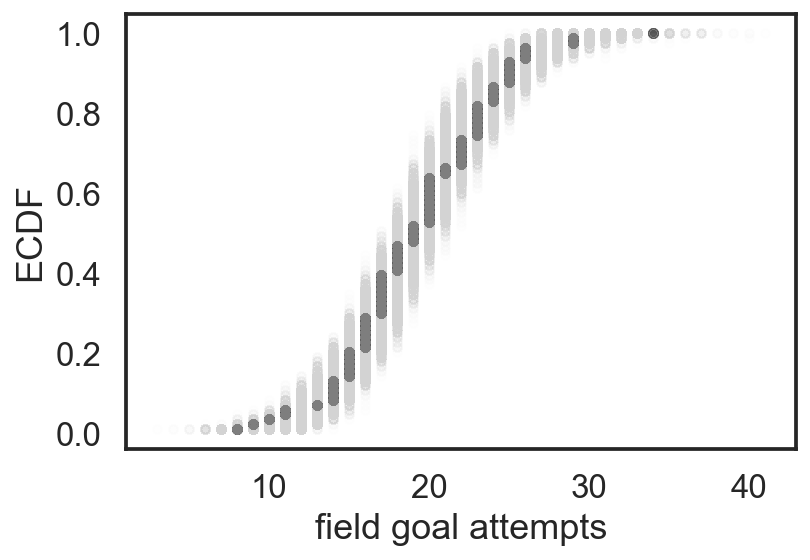

In [29]:
# Number of times we simulate the model
n_reps = 1000

# Plot ECDF of data
plt.plot(x_ecdf, y_ecdf, '.', color='black');

# Plot ECDF of model
for _ in range(n_reps):
    samples = np.random.poisson(np.mean(fga), size=len(fga))
    x_theor, y_theor = ecdf(samples)
    plt.plot(x_theor, y_theor, '.', alpha=0.01, color='lightgray');


# Label your axes
plt.xlabel('field goal attempts')
plt.ylabel('ECDF')

You can see from the ECDF that LeBron's field goal attempts per game are Poisson distributed.

## 1.5 Exponential distribution<a id="15">

We've encountered a variety of named _discrete distributions_. There are also named _continuous distributions_, such as the Exponential distribution and the Normal (or Gaussian) distribution. To see what the story of the Exponential distribution is, let's return to Poissonville, in which the number of buses that will arrive per hour are Poisson distributed.
However, the waiting time between arrivals of a Poisson process are exponentially distributed.

So: the exponential distribution has the following story: the waiting time between arrivals of a Poisson process are exponentially distributed. It has a single parameter, the mean waiting time. This distribution is not peaked, as we can see from its PDF.

For an illustrative example, lets check out the time between all incidents involving nuclear power since 1974. It's a reasonable first approximation to expect incidents to be well-modeled by a Poisson process, which means the timing of one incident is independent of all others. If this is the case, the time between incidents should be Exponentially distributed.


To see if this story is credible, we can plot the ECDF of the data with the CDF that we'd get from an exponential distribution with the sole parameter, the mean, given by the mean inter-incident time of the data.


In [30]:
# Load nuclear power accidents data & create array of inter-incident times
df = pd.read_csv('../data/nuclear_power_accidents.csv')
df.Date = pd.to_datetime(df.Date)
df = df[df.Date >= pd.to_datetime('1974-01-01')]
inter_times = np.diff(np.sort(df.Date)).astype(float) / 1e9 / 3600 / 24

In [31]:
# Compute mean and sample from exponential
mean = np.mean(inter_times)
samples = np.random.exponential(mean, size=10**6)

# Compute ECDFs for sample & model
x, y = ecdf(inter_times)
x_theor, y_theor = ecdf(samples)

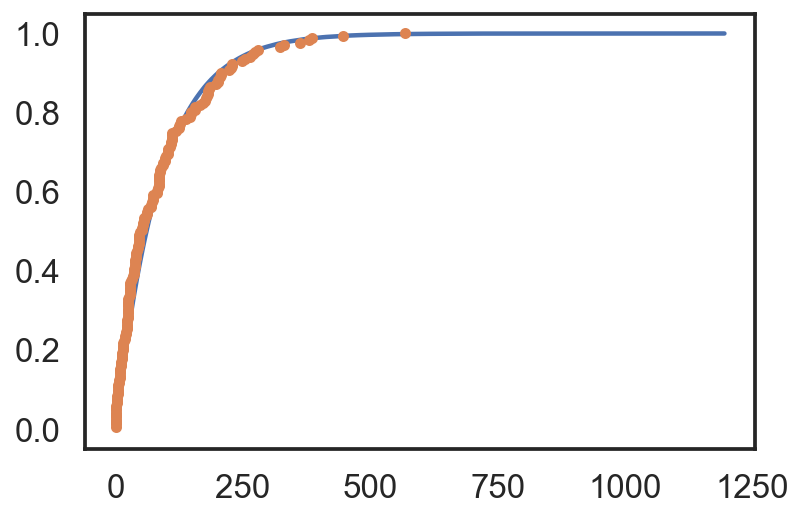

In [32]:
# Plot sample & model ECDFs
plt.plot(x_theor, y_theor);
plt.plot(x, y, marker='.', linestyle='none');

We see that the data is close to being Exponentially distributed, which means that we can model the nuclear incidents as a Poisson process.

## 1.6 Normal distribution<a id="16">

The Normal distribution, also known as the Gaussian or Bell Curve, appears everywhere. There are many reasons for this. One is the following:

> When doing repeated measurements, we expect them to be Normally distributed, owing to the many subprocesses that contribute to a measurement. This is because (a formulation of the Central Limit Theorem) **any quantity that emerges as the sum of a large number of subprocesses tends to be Normally distributed** provided none of the subprocesses is very broadly distributed.

Now it's time to see if this holds for the measurements of the speed of light in the famous Michelson–Morley experiment:

Below, I'll plot the histogram with a Gaussian curve fitted to it. Even if that looks good, though, that could be due to binning bias. SO then you'll plot the ECDF of the data and the CDF of the model!

Text(0, 0.5, 'PDF')

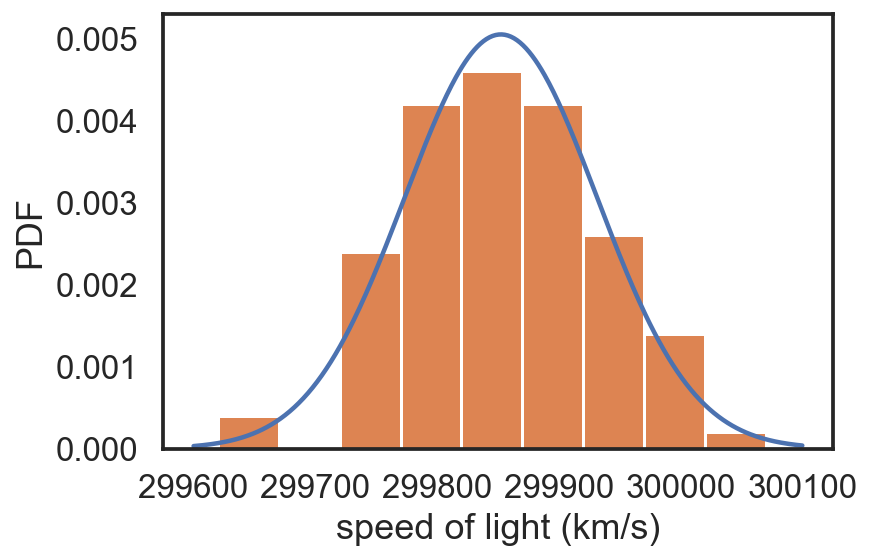

In [33]:
# Load data, plot histogram 
df = pd.read_csv('../data/michelson_speed_of_light.csv')
df = df.rename(columns={'velocity of light in air (km/s)': 'c'})
c = df.c.values
x_s = np.linspace(299.6, 300.1, 400) * 1000
plt.plot(x_s, st.norm.pdf(x_s, c.mean(), c.std(ddof=1)))
plt.hist(c, bins=9, density=True)
plt.xlabel('speed of light (km/s)')
plt.ylabel('PDF')

Here we again import a dataset of 3D selection experiment.

![selection](../images/app-3dtouch-device.png)

In [34]:
df = pd.read_csv('../data/user1_raw_log.csv')
df.head()

completion_time  spatial_errors  target_distance
0           1680.0           13.27                2
1           1660.0            5.69                2
2           1100.0            0.04                1
3           1220.0            4.21                1
4           1840.0            2.21                3

Text(0, 0.5, 'PDF')

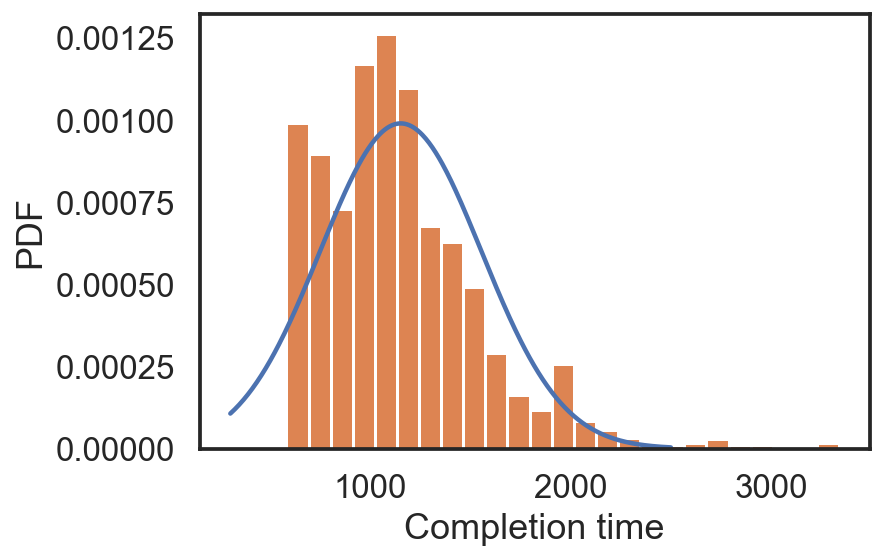

In [35]:
df = df.rename(columns={'completion_time': 'c'})
c = df.c.values
x_s = np.linspace(300, 2500, 400)
plt.plot(x_s, st.norm.pdf(x_s, c.mean(), c.std(ddof=1)))
plt.hist(c, bins=25, density=True)
plt.xlabel('Completion time')
plt.ylabel('PDF')

Why it's not normally distributed? Because it's not repeated measurments of the same task.

#### Hands-on: Simulating Normal

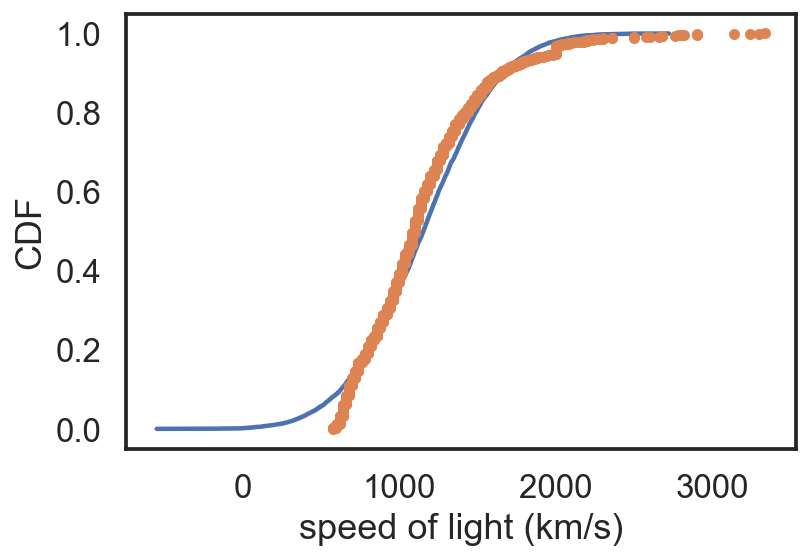

In [36]:
# Get speed of light measurement + mean & standard deviation
michelson_speed_of_light = df.c.values
mean = np.mean(michelson_speed_of_light)
std = np.std(michelson_speed_of_light, ddof=1)

# Generate normal samples w/ mean,  std of data
samples = np.random.normal(mean, std, size=10000)

# Generate data ECDF & model CDF
x, y = ecdf(michelson_speed_of_light)
x_theor, y_theor = ecdf(samples)

# Plot data & model (E)CDFs
_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.xlabel('speed of light (km/s)')
_ = plt.ylabel('CDF')

### Optional reading:

One important thing we did not mention here is how do we sample a sequence of pointsfrom a probability distribution?  
The answer is an algorithm called **Metropolis–Hastings algorithm**, which is an algorithm under the **Markov Chain Monte Carlo (MCMC)** methods. The most important quality of such Metropolis-Hastings algorithm is that if we make enough sample, the resulting samples will converge to the original probability distribution.

You can read more from here: https://people.duke.edu/~ccc14/sta-663/MCMC.html

<div class="alert alert-block alert-danger">
<h2><img src="../images/warning.png" width="20", align="left">&nbsp;Warning</h2>
    <br>Make sure you are a Bayesian now: <br>
    You (at least partially) agree that probability is credibility points assigned over a region that we can use for generating data.</div>

<a href="#outline">Going back to outline</a>

----

# Part 2: Bayes Theorem and Bayesian Inference<a id="2">

We have established a solid understanding of _probability_, and we learned how to create synthetic data from a probability distribution. We are about to see the other side of Bayesian probability, that is, inferring the probability distribution based on our sampled observations.


<div class="alert alert-block alert-success">
<h2><img src="../images/goal.png" width=20, align="left">&nbsp;Learning objectives of part 2</h2>
    <br>Learn to:
    <ul>
        <li>know joint probabilities and conditional probabilities
        <li>understand Bayes' Theorem and its utility
        <li>understand what priors, likelihoods and posteriors are
        <li>Use random sampling for parameter estimation to appreciate the relationship between sample size & the posterior distribution, along with the effect of the prior.
    </ul>
</div>


## 2.1 Conditional and  Joint Probability <a id="21">

### Joint Probability

$P(A,B)$ is the probability two events $A$ and $B$ _both_ occurring.
* For example, getting two heads in a row.

If $A$ and $B$ are independent, then $P(A,B)=P(A)P(B)$ but be warned: this is not always (or often) the case.

One way to think of this is considering "AND" as multiplication: the probability of A **and** B is the probability of A **multiplied** by the probability of B (if they are independent!).

#### Hands-On: Joint Probability and Coin Flipping

Verify that $P(A,B)=P(A)P(B)$ in the two fair coin-flip case (A=heads, B=heads) by 
- first simulating two coins being flipped together and calculating the proportion of occurences with two heads;
- then simulating one coin flip and calculating the proportion of heads and then doing that again and multiplying the two proportions.

Your two calculations should give "pretty close" results and not the same results due to the (in)accuracy of simulation. 

0.2495


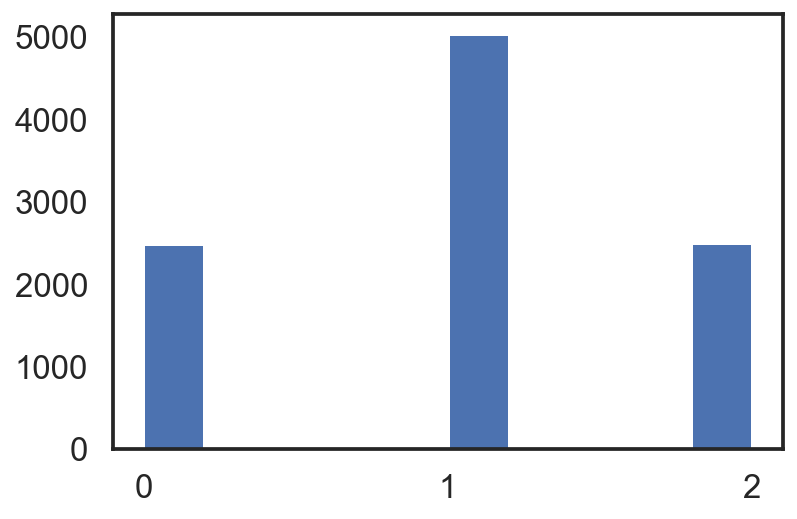

In [37]:
# Solution: Calculate P(A,B)
x_0 = np.random.binomial(2, 0.5, 10000)
p_ab = sum(x_0==2)/len(x_0)

# Now, plot the histogram of the results
fig, ax = plt.subplots()
ax.hist(x_0)
ax.set_xticks([0,1,2])
print(p_ab)

In [38]:
# Solution: Calculate P(A)P(B)
x_1 = np.random.binomial(1, 0.5, 10000)
x_2 = np.random.binomial(1, 0.5, 10000)
p_a = sum(x_1 == 1)/len(x_1)
p_b = sum(x_2 == 1)/len(x_2)
p_a*p_b

0.25574146000000003

### Let's try with real data

In [39]:
# Import and view head of data
df_12 = pd.read_csv('../data/user1_raw_log.csv')
df_12.head()

completion_time  spatial_errors  target_distance
0           1680.0           13.27                2
1           1660.0            5.69                2
2           1100.0            0.04                1
3           1220.0            4.21                1
4           1840.0            2.21                3

What is the probability of completion_time > 1200 -- p(A)?  
What is the probability of spatial_error > 10 -- p(B)?
 
If the two events are independent, what will be the joint probability (calculate p(A) x p(B))

In [40]:
p_ct = sum(df_12.completion_time > 1200)/len(df_12)
print ('The probability of completion time > 1200 =', p_ct)

p_se = sum(df_12.spatial_errors > 10)/len(df_12)
print ('The probability of spatial error > 10 =', p_se)
print ()

### If A and B are independent, then P(A,B)=P(A)P(B)
### but be warned: this is not always (or often) the case.
print ("If independent, the joint probability is = ", p_ct * p_se)

The probability of completion time > 1200 = 0.36672850958565245
The probability of spatial error > 10 = 0.17316017316017315

If independent, the joint probability is =  0.0635027722226238


What is the actual joint probability of p(A,B)?

In [41]:
df_c_time_12 = df_12.loc[df_12['completion_time'] > 1200]
p_a_n_b = sum((df_c_time_12.spatial_errors > 10)/len(df_12))
print ("The actual joined probability is = ",round (p_a_n_b, 6))

The actual joined probability is =  0.114409


### Conditional Probability

Now that we have a grasp on joint probabilities, lets consider conditional probabilities, that is, the probability of some $A$, knowing that some other $B$ is true. We use the notation $P(A|B)$ to denote this.  

Conditional and joint probabilites are related by the following:
$$ P(A,B) = P(A|B)P(B)$$

Calculate the conditional probability, p(A|B), of spatial error > 10 (A), given completion time > 1200 (B):

In [42]:
df_c_time_12 = df_12.loc[df_12['completion_time'] > 1200]
p_s10_given_c12 = sum(df_c_time_12.spatial_errors > 10)/len(df_c_time_12)
print ("The probability of having spatial error > 10 given completion time > 1200 = ", p_s10_given_c12)

The probability of having spatial error > 10 given completion time > 1200 =  0.31197301854974707


### Hands-on:  
Calculate the joined probability of spatial error > 10 (A) and completion time > 1200 (B) using **conditional probability**

In [43]:
p_joint = round(p_s10_given_c12 * p_ct ,6)
print ("If we use the conditional probability to calculate the joint probability, we get ",  p_joint)

If we use the conditional probability to calculate the joint probability, we get  0.114409


## 2.2 Bayes Theorem <a id="22">

$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$

![bayes](../images/bayes_theo2.png)

### The cookie problem
There are two bowls of cookies: 
- Bowl #1 has 10 chocolate and 30 vanilla
- Bowl #2 has 20 chocolate and 20 vanilla

You pick a bowl at random, and pick a cookie at random,
the cookie turns out to be vanilla. 


What is the probability that you pick Bowl #1?

`Pmf.from_seq` makes a `Pmf` object from a sequence of values.

Here's how we can use it to create a `Pmf` with two equally likely hypotheses.

In [44]:
cookie = Pmf.from_seq(['Bowl 1', 'Bowl 2'])
cookie

Bowl 1    0.5
Bowl 2    0.5
dtype: float64

In [45]:
cookie['Bowl 1'] *= 0.75
cookie['Bowl 2'] *= 0.5
cookie.normalize()
cookie

Bowl 1    0.6
Bowl 2    0.4
dtype: float64

### Hands-on: 
    
Suppose we put the first cookie back, stir, choose again from the same bowl, and get a chocolate cookie.  
What are the posterior probabilities after the second cookie?

Hint: The posterior (after the first cookie) becomes the prior (before the second cookie).

In [46]:
# Solution

cookie = Pmf.from_seq(['Bowl 1', 'Bowl 2'])
cookie['Bowl 1'] *= 0.75 * 0.25
cookie['Bowl 2'] *= 0.5 * 0.5
cookie.normalize()
cookie

Bowl 1    0.428571
Bowl 2    0.571429
dtype: float64

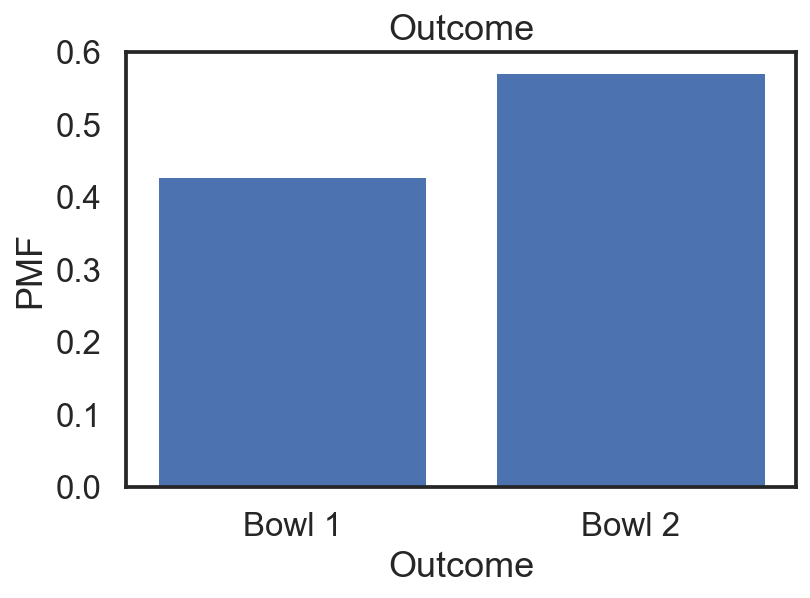

In [47]:
def decorate_cookie(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Outcome')
    plt.ylabel('PMF')
    plt.title(title)

cookie.bar()
decorate_cookie('Outcome')

<div class="alert alert-block alert-danger">
<h2><img src="../images/warning.png" width="20", align="left">&nbsp;Warning</h2>
    <br>You should have a clear idea what is Bayes Theorem and what is Bayesian update! Important concepts include: Prior (the hypothesis without data), Likelihood (given the hypothesis, what is the chance to see the data), Posterior (the updated hypothesis after seeing data).
</div>

### Working with Pmfs

Let's get a bit more familiar with the Pmf package by creating a Pmf object to represent a six-sided die.

In [48]:
d6 = Pmf()

# A Pmf is a map from possible outcomes to their probabilities.
# Let's create a fair dice

for x in [1,2,3,4,5,6]:
    d6[x] = 1
    
d6

1    1
2    1
3    1
4    1
5    1
6    1
dtype: int64

`normalize` adds up the probabilities and divides through.  The return value is the total probability before normalizing.

In [49]:
d6.normalize()

d6

1    0.166667
2    0.166667
3    0.166667
4    0.166667
5    0.166667
6    0.166667
dtype: float64

In [50]:
## And we can compute its mean (which only works if it's normalized).

print (d6.mean())


## choice(size=n) chooses a random values from the Pmf.

print (d6.choice(size=10))

3.5
[6 3 3 5 6 3 4 1 6 6]


`bar` plots the Pmf as a bar chart

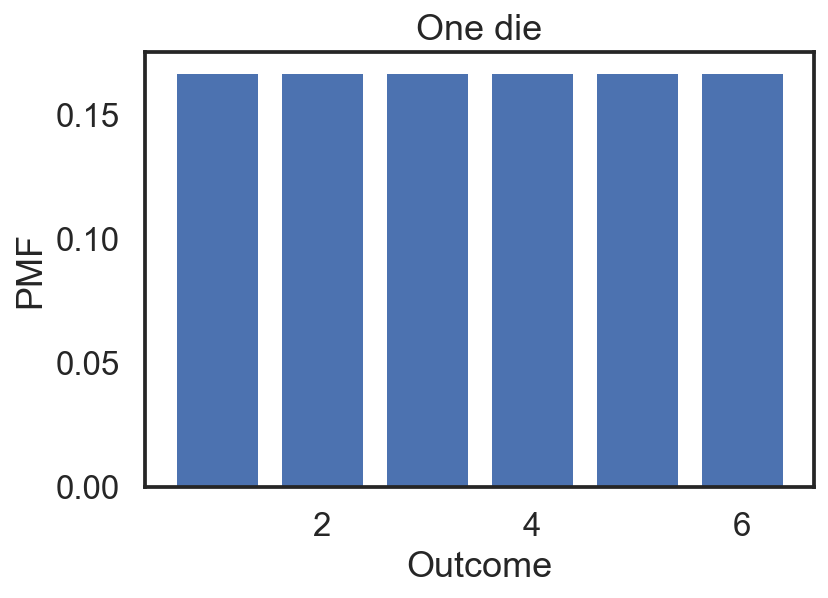

In [51]:
def decorate_dice(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Outcome')
    plt.ylabel('PMF')
    plt.title(title)
    
d6.bar()
decorate_dice('One die')

`d6.add_dist(d6)` creates a new `Pmf` that represents the sum of two six-sided dice.

In [52]:
twice = d6.add_dist(d6)
twice

2     0.027778
3     0.055556
4     0.083333
5     0.111111
6     0.138889
7     0.166667
8     0.138889
9     0.111111
10    0.083333
11    0.055556
12    0.027778
dtype: float64

In [53]:
third = twice.add_dist(d6)
third

3     0.004630
4     0.013889
5     0.027778
6     0.046296
7     0.069444
8     0.097222
9     0.115741
10    0.125000
11    0.125000
12    0.115741
13    0.097222
14    0.069444
15    0.046296
16    0.027778
17    0.013889
18    0.004630
dtype: float64

### Hands-on:
Plot the distribution of twice and calculate the mean.

6.999999999999998

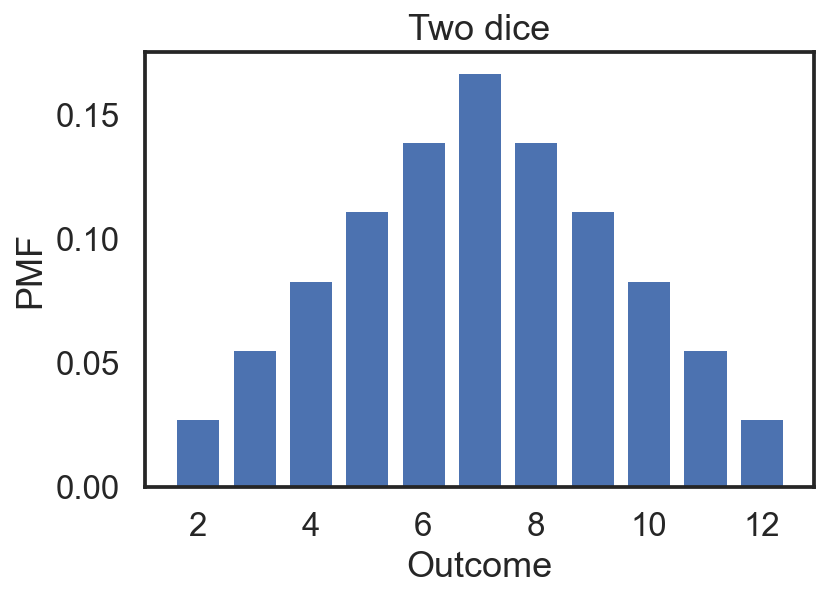

In [54]:
twice.bar()
decorate_dice('Two dice')
twice.mean()

### The dice problem

Create a suite of hypotheses that represents dice with different numbers of sides.

In [55]:
# Dice 4 has 4 faces, Dice 6 has 6 faces, ...
dice = Pmf.from_seq([4, 6, 8, 12])
dice

4     0.25
6     0.25
8     0.25
12    0.25
dtype: float64

We'll solve this problem two ways.  First we'll do it "by hand", as we did with the cookie problem; that is, we'll multiply each hypothesis by the likelihood of the data, and then renormalize.

### Hands-on:
In the space below, update `dice` based on the likelihood of the data (rolling a 6), then normalize and display the results.

In [56]:
# Solution

dice[4] *= 0
dice[6] *= 1/6
dice[8] *= 1/8
dice[12] *= 1/12

dice.normalize()
dice

4     0.000000
6     0.444444
8     0.333333
12    0.222222
dtype: float64

### Hands-on:

Now let's do the same calculation using `Pmf.update`, which encodes the structure of a Bayesian update.

Define a function called `likelihood_dice` that takes `data` and `hypo` and returns the probability of the data (the outcome of rolling the die) for a given hypothesis (number of sides on the die).

Hint: What should you do if the outcome exceeds the hypothetical number of sides on the die?

Here's an outline to get you started.

In [57]:
def likelihood_dice(data, hypo):
    """Likelihood function for the dice problem.
    
    data: outcome of the die roll
    hypo: number of sides
    
    returns: float probability
    """
    # TODO: fill this in!
    return 1

In [58]:
# Solution
    
def likelihood_dice(data, hypo):
    """Likelihood function for the dice problem.
    
    data: outcome of the die roll
    hypo: number of sides
    
    returns: float probability
    """
    if data > hypo:
        return 0
    else:
        return 1 / hypo

In [59]:
# Now we can create a Pmf object and update it.

dice = Pmf.from_seq([4, 6, 8, 12])
dice.update(likelihood_dice, 6)
dice

4     0.000000
6     0.444444
8     0.333333
12    0.222222
dtype: float64

### Hands-on:

Create another Pmf object that update three times (got 6, 7, and 8). 

In [60]:
# Solution

dice = Pmf.from_seq([4, 6, 8, 12])
dice.update(likelihood_dice, 6)
dice.update(likelihood_dice, 7)
dice.update(likelihood_dice, 8)
dice

4     0.000000
6     0.000000
8     0.771429
12    0.228571
dtype: float64

If we get more data, we can perform more updates.

In [61]:
dice = Pmf.from_seq([4, 6, 8, 12])
for roll in [8, 7, 7, 5, 4]:
    dice.update(likelihood_dice, roll)
dice

4     0.000000
6     0.000000
8     0.883636
12    0.116364
dtype: float64

### The Euro problem

*"When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110.  'It looks very suspicious to me,' said Barry Blight, a statistics lecturer at the London School of Economics.  'If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7%.' "*

From “The Guardian” quoted by MacKay, *Information Theory, Inference, and Learning Algorithms*.


### Hands-on:
Write a function called `likelihood_euro` that defines the likelihood function for the Euro problem.  Note that `hypo` is in the range 0 to 100.

Here's an outline to get you started.

In [62]:
def likelihood_euro(data, hypo):
    """ Likelihood function for the Euro problem.
    
    data: string, either 'H' or 'T'
    hypo: prob of heads (0-100)
    
    returns: float probability
    """
    # TODO: fill this in!
    return 1

In [63]:
# Solution

def likelihood_euro(data, hypo):
    """ Likelihood function for the Euro problem.
    
    data: string, either 'H' or 'T'
    hypo: prob of heads (0-100)
    
    returns: float probability
    """
    x = hypo / 100
    if data == 'H':
        return x
    else:
        return 1-x

In [64]:
def decorate_euro(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Probability of heads')
    plt.ylabel('PMF')
    plt.title(title)

We start from a uniform distribution

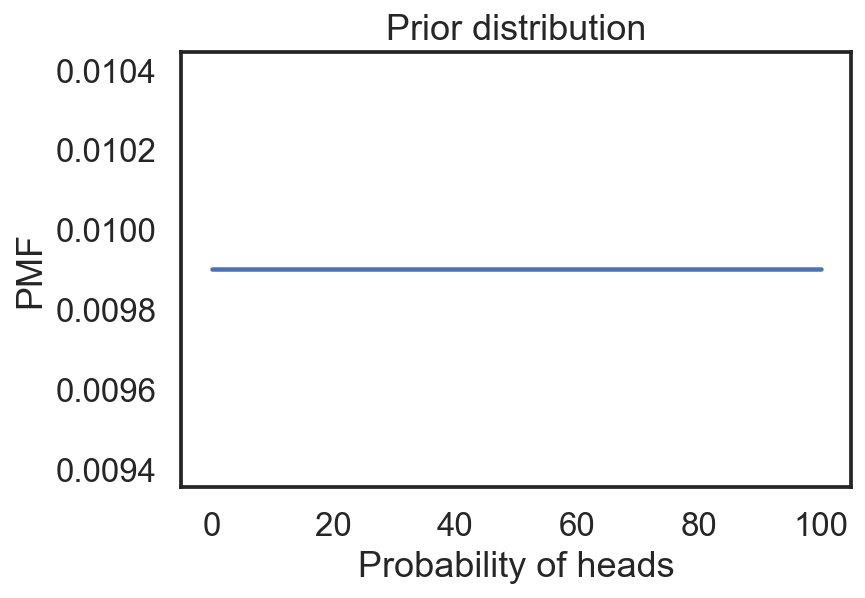

In [65]:
euro = Pmf.from_seq(range(101))
euro.plot()
decorate_euro('Prior distribution')

Now we can update with a single head:

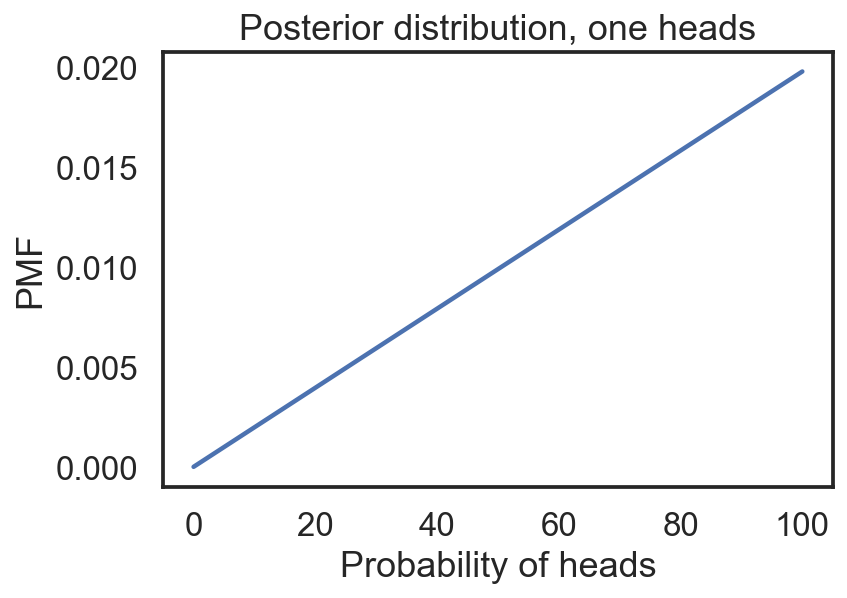

In [66]:
euro.update(likelihood_euro, 'H')
euro.plot()
decorate_euro('Posterior distribution, one heads')

Another head:

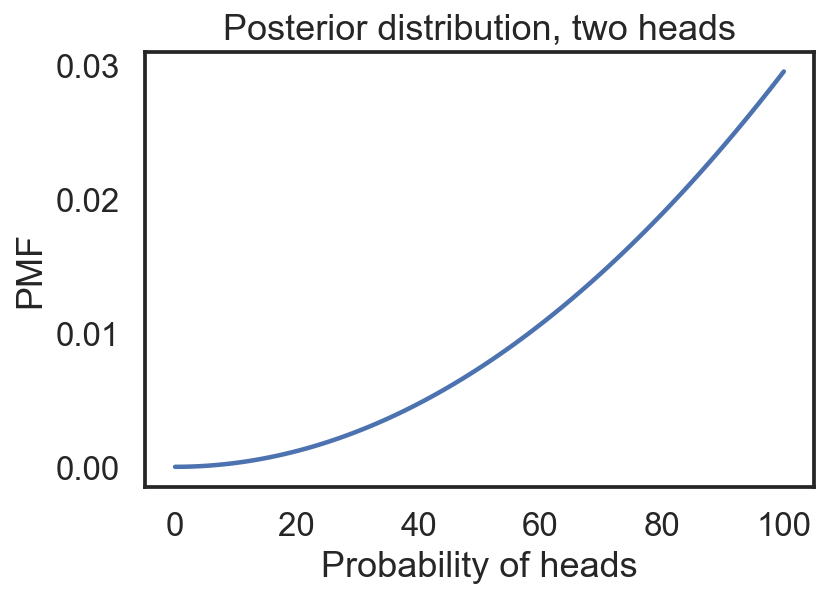

In [67]:
euro.update(likelihood_euro, 'H')
euro.plot()
decorate_euro('Posterior distribution, two heads')

And a tail:

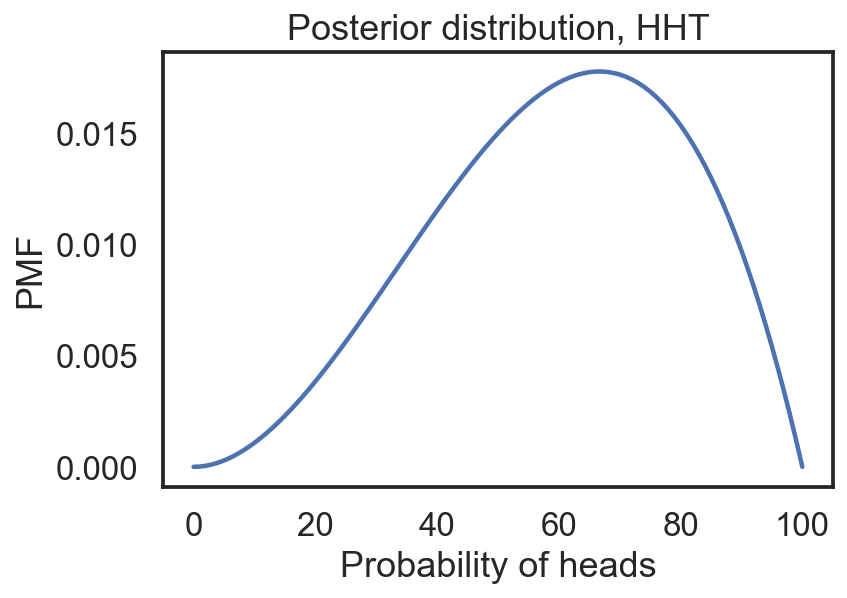

In [68]:
euro.update(likelihood_euro, 'T')
euro.plot()
decorate_euro('Posterior distribution, HHT')

Starting over, here's what it looks like after 4 heads and 2 tails.

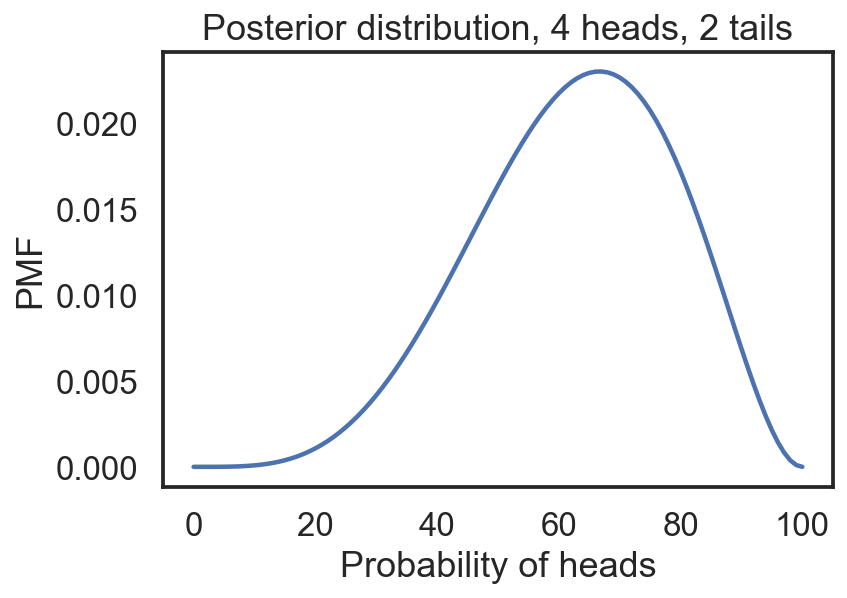

In [69]:
euro = Pmf.from_seq(range(101))

for outcome in 'HHHHTT':
    euro.update(likelihood_euro, outcome)

euro.plot()
decorate_euro('Posterior distribution, 4 heads, 2 tails')

The Maximum aposteriori probability (MAP) is 67%.

In [70]:
euro.max_prob()

67

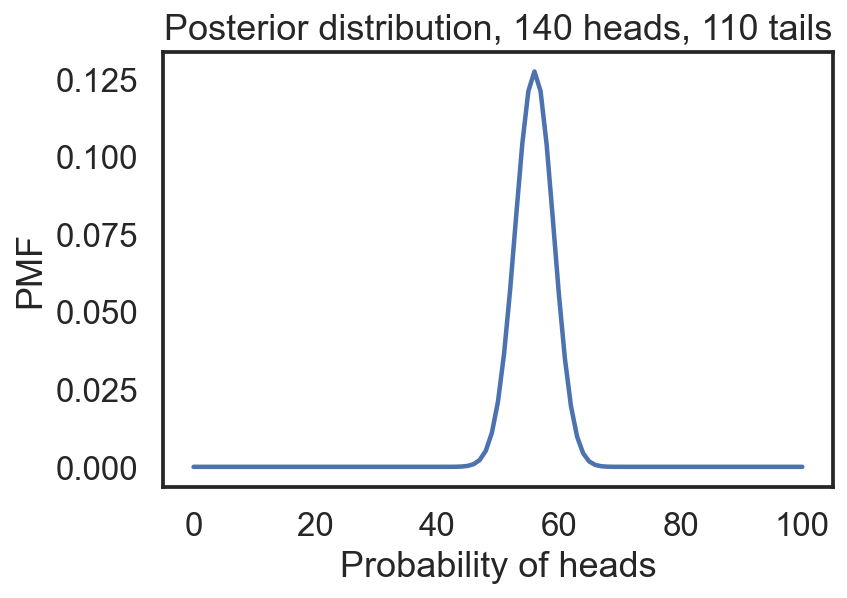

In [71]:
euro = Pmf.from_seq(range(101))

evidence = 'H' * 140 + 'T' * 110
for outcome in evidence:
    euro.update(likelihood_euro, outcome)
    
euro.plot()

decorate_euro('Posterior distribution, 140 heads, 110 tails')

The posterior mean is about 55.92%  
The maximum apostiori probability (MAP) is 56%  
The medium value is also 56%

In [72]:
print (euro.mean())
print (euro.max_prob()) # Maximum apostiori probability
print (euro.quantile(0.5)) # Medium

55.95238095238095
56
56.0


The posterior credible interval has a 90% chance of containing the true value  
(provided that the prior distribution truly represents our background knowledge).

In [73]:
euro.credible_interval(0.9)

array([51., 61.])

### Swamping the prior

The following function makes a Euro object with a triangle prior.

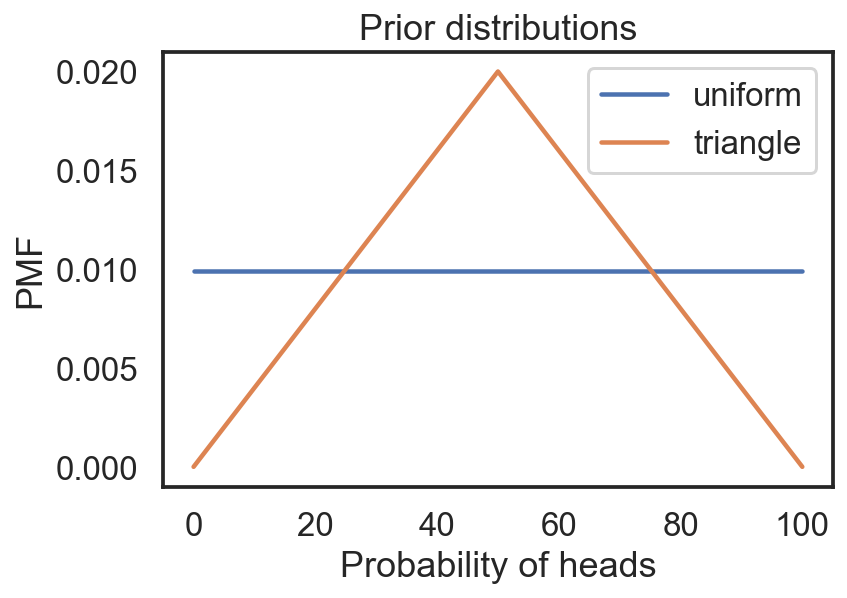

In [74]:
def TrianglePrior():
    """Makes a Suite with a triangular prior.
    """
    suite = Pmf(name='triangle')
    for x in range(0, 51):
        suite[x] = x
    for x in range(51, 101):
        suite[x] = 100-x 
    suite.normalize()
    return suite

euro1 = Pmf.from_seq(range(101), name='uniform')
euro1.plot()

euro2 = TrianglePrior()
euro2.plot()

plt.legend()
decorate_euro('Prior distributions')

### Hands-on
1. Update `euro1` and `euro2` with the same data (4 heads and 2 tails) and plot the posteriors.  How big is the difference in means?

2. Update `euro1` and `euro2` with the same data (40 heads and 20 tails) and plot the posteriors.  How big is the difference in means?

(62.499997812718675, 58.604627060579226)

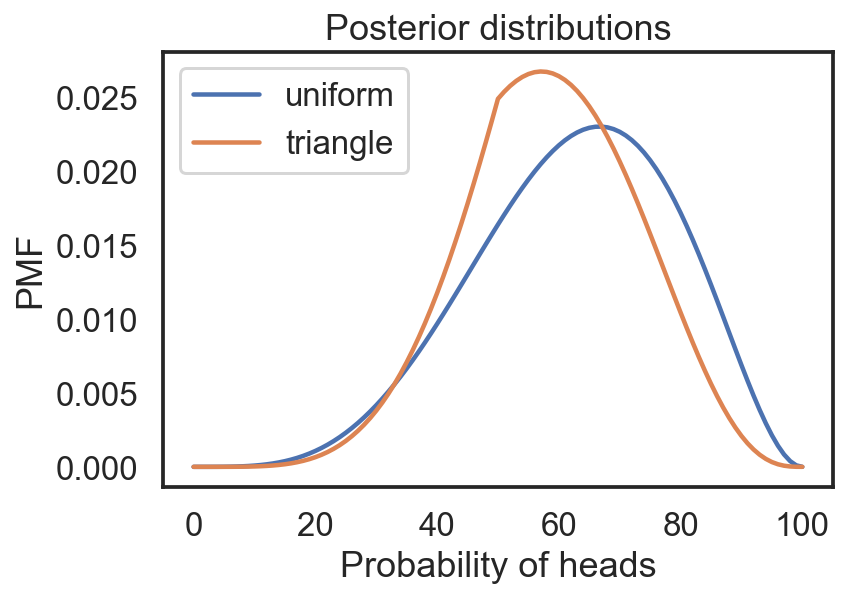

In [75]:
# Solution

evidence = 'H' * 4 + 'T' * 2
for outcome in evidence:
    euro1.update(likelihood_euro, outcome)
    euro2.update(likelihood_euro, outcome)

euro1.plot()
euro2.plot()

decorate_euro('Posterior distributions')
plt.legend()

euro1.mean(), euro2.mean()

(66.12903225806451, 65.09028453076183)

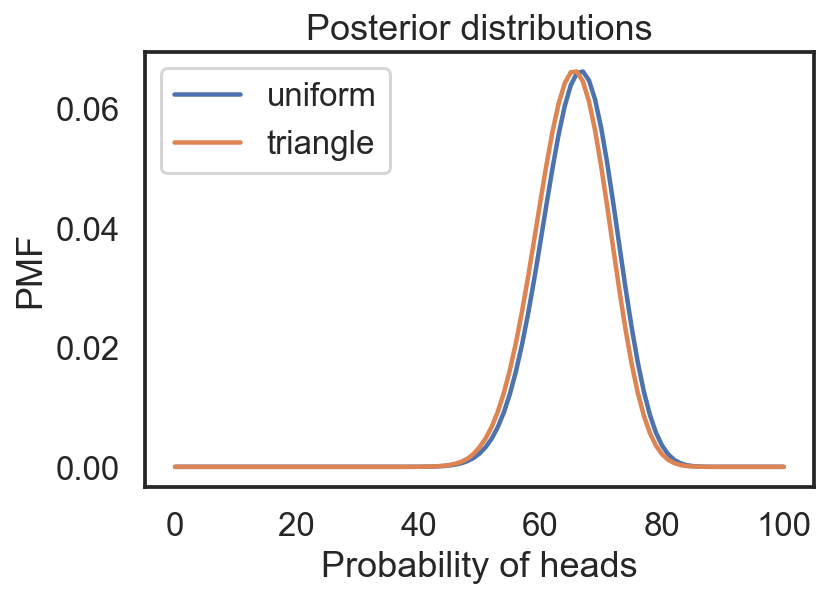

In [76]:
# Solution

euro1 = Pmf.from_seq(range(101), name='uniform')

euro2 = TrianglePrior()


evidence = 'H' * 40 + 'T' * 20
for outcome in evidence:
    euro1.update(likelihood_euro, outcome)
    euro2.update(likelihood_euro, outcome)

euro1.plot()
euro2.plot()

decorate_euro('Posterior distributions')
plt.legend()

euro1.mean(), euro2.mean()

## 2.3 From Bayes' Theorem to (Simulated) Bayesian Inference <a id='23'>

Let's say that we flip a biased coin several times and we want to estimate the probability of heads from the number of heads we saw. Statistical intuition tells us that our best estimate of $p(heads)=$ number of heads divided by total number of flips.

However, 

1. It doesn't tell us how certain we can be of that estimate and
2. This type of intuition doesn't extend to even slightly more complex examples.

Bayesian inference helps us here. We can calculate the probability of a particular $p=p(H)$ given data $D$ by setting $A$ in Bayes Theorem equal to $p$ and $B$ equal to $D$.

$$P(p|D) = \frac{P(D|p)P(p)}{P(D)} $$
  


In this equation, we call $P(p)$ the prior (distribution), $P(D|p)$ the likelihood and $P(p|D)$ the posterior (distribution). The intuition behind the nomenclature is as follows: the prior is the distribution containing our knowledge about $p$ prior to the introduction of the data $D$ & the posterior is the distribution containing our knowledge about $p$ after considering the data $D$.

  
**Note** that we're _overloading_ the term _probability_ here. In fact, we have 3 distinct usages of the word:
- The probability $p$ of seeing a head when flipping a coin;
- The resulting binomial probability distribution $P(D|p)$ of seeing the data $D$, given $p$;
- The prior & posterior probability distributions of $p$, encoding our _uncertainty_ about the value of $p$.

**Key concept:** We only need to know the posterior distribution $P(p|D)$ up to multiplication by a constant at the moment: this is because we really only care about the values of $P(p|D)$ relative to each other – for example, what is the most likely value of $p$? To answer such questions, we only need to know what $P(p|D)$ is proportional to, as a function of $p$. Thus we don’t currently need to worry about the term $P(D)$. In fact,

$$P(p|D) \propto P(D|p)P(p) $$

**Note:** What is the prior? Really, what do we know about $p$ before we see any data? Well, as it is a probability, we know that $0\leq p \leq1$. If we haven’t flipped any coins yet, we don’t know much else: so it seems logical that all values of $p$ within this interval are equally likely, i.e., $P(p)=1$, for $0\leq p \leq1$. This is known as an uninformative prior because it contains little information (there are other uninformative priors we may use in this situation, such as the Jeffreys prior, to be discussed later). People who like to hate on Bayesian inference tend to claim that the need to choose a prior makes Bayesian methods somewhat arbitrary, but as we’ll now see, if you have enough data, the likelihood dominates over the prior and the latter doesn’t matter so much.


**Essential remark:** we get the whole distribution of $P(p|D)$, not merely a point estimate plus errors bars, such as [95% confidence intervals](http://andrewgelman.com/2018/07/04/4th-july-lets-declare-independence-95/).


### Bayesian inference using simulated data: flip those coins

Now let's generate some coin flips and try to estimate $p(H)$. Two notes:
- given data $D$ consisting of $n$ coin tosses & $k$ heads, the likelihood function is given by $L:=P(D|p) \propto p^k(1-p)^{n-k}$;
- given a uniform prior, the posterior is proportional to the likelihood.

### Discussion: 
What is the distribution we should use for simulating data of coin flip?

In [77]:
def plot_posterior(p=0.6, N=0):
    """Plot the posterior given a uniform prior; Bernoulli trials
    with probability p; sample size N"""
    # Set seed
    np.random.seed(42)

    # Flip coins 
    n_successes = np.random.binomial(N, p)
    
    # X-axis for PDF
    x = np.linspace(0, 1, 100)
    
    # Write out equation for uniform prior
    prior = np.ones(len(x))
    
    # Write out equation for posterior, which is likelihood * prior.
    posterior = (x**n_successes) * ((1-x)**(N-n_successes)) * prior
    
    # Pseudo-normalize the posterior so that we can compare them on the same scale.
    posterior /= np.max(posterior)  
    
    # Plot posterior
    plt.plot(x, posterior)
    plt.show()

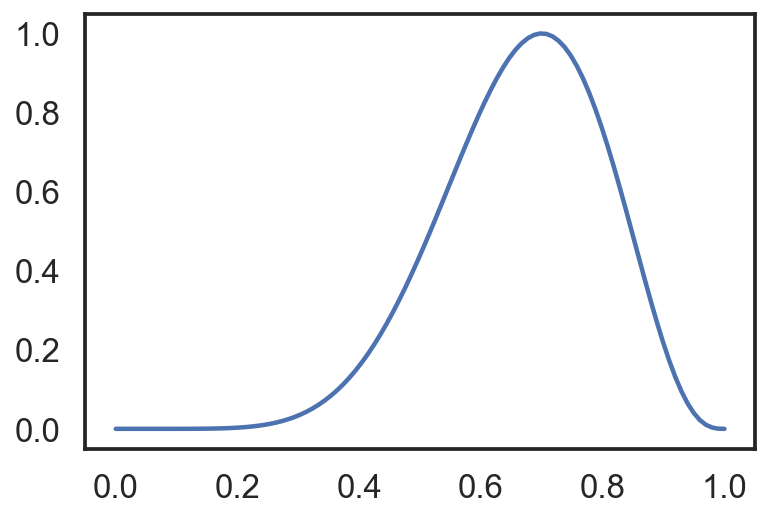

In [78]:
plot_posterior(N=10)

In [79]:
interact(plot_posterior, p=(0, 1, 0.01), N=(0, 150));

interactive(children=(FloatSlider(value=0.6, description='p', max=1.0, step=0.01), IntSlider(value=0, descript…

As you generate more and more data, your posterior gets narrower, i.e. you get more and more certain of your estimate.

### The choice of the prior

You may have noticed that we needed to choose a prior and that, in the small to medium data limit, this choice can affect the posterior. We'll briefly introduce several types of priors and then you'll use one of them for the example above to see the effect of the prior:

- **Informative priors** express specific, definite information about a variable, for example, if we got a coin from the mint, we may use an informative prior with a peak at $p=0.5$ and small variance. 
- **Weakly informative priors** express partial information about a variable, such as a peak at $p=0.5$ (if we have no reason to believe the coin is biased), with a larger variance.
- **Uninformative priors** express no information about a variable, except what we know for sure, such as knowing that $0\leq p \leq1$.

Now you may think that the _uniform distribution_ is uninformative, however, what if I am thinking about this question in terms of the probability $p$ and Jeffreys is thinking about it in terms of the _odds ratio_ $r=\frac{p}{1-p}$? Jeffreys rightly feels that he has no prior knowledge as to what this $r$ is and thus chooses the uniform prior on $r$.

With a bit of algebra (transformation of variables), we can show that choosing the uniform prior on $p$ amounts to choosing a decidedly non-uniform prior on $r$ and vice versa. So Jeffryes and I have actually chosen different priors, using the same philosophy. How do we avoid this happening? Enter the **Jeffreys prior**, which is an uninformative prior that solves this problem. You can read more about the Jeffreys prior [here](https://en.wikipedia.org/wiki/Jeffreys_prior). 

In the binomial (coin flip) case, the Jeffreys prior is given by $P(p) = \frac{1}{\sqrt{p(1-p)}}$.

In [80]:
# Write the plotting function, as above
def plot_posteriors(p=0.6, N=0):
    np.random.seed(42)
    n_successes = np.random.binomial(N, p)
    x = np.linspace(0.01, 0.99, 100)

    # Write out the likelihood for the data
    likelihood = x**n_successes*(1-x)**(N-n_successes) 
    
    # Write out equation for posterior given uniform prior
    prior_uniform = np.ones(len(x))
    posterior_uniform = likelihood * prior_uniform
    posterior_uniform /= np.max(posterior_uniform)
    plt.plot(x, posterior_uniform, label='Uniform prior')
    
    # Write out equation for posterior given Jeffreys prior
    prior_jeffreys = np.sqrt(x*(1-x))**(-1)
    posterior_jeffreys = likelihood * prior_jeffreys
    posterior_jeffreys /= np.max(posterior_jeffreys)
    plt.plot(x, posterior_jeffreys, label='Jeffreys prior')
    plt.legend()
    plt.show()

In [81]:
interact(plot_posteriors, p=(0, 1, 0.01), N=(0, 50));

interactive(children=(FloatSlider(value=0.6, description='p', max=1.0, step=0.01), IntSlider(value=0, descript…

### Simulation from a model based on known user data

Here we import again the dataset of 3D selection experiment that was used in our recently submitted paper. We want to learn the probability distribution of user is able to complete a selection under 1 second.

![selection](../images/app-3dtouch-device.png)

In [82]:
# Import and view head of data
df_12 = pd.read_csv('../data/user1_raw_log.csv')
df_12.head()

# Store lengths in a pandas series
c_time = df_12['completion_time']

p = (sum(c_time < 1000))/len(c_time)
print(p)

0.3821892393320965


In [83]:
interact(plot_posteriors, p=p, N=(0, 50));

interactive(children=(FloatSlider(value=0.3821892393320965, description='p', max=1.1465677179962894, min=-0.38…

<div class="alert alert-block alert-danger">
<h2><img src="../images/warning.png" width="20", align="left">&nbsp;Warning</h2>
    <br>Good job! You have learned what is "probability" and have generated data from a distribution. Furthermore, you have a clear idea what is Bayes Theorem and its application as an inference tool.
</div>

<a href="#outline">Going back to outline</a>

-----
# Part 3: Bayesian Statistical Analysis with PyMC3 <a id='3'>

Okay! We have a thorough understanding of Bayesian probability (part 0), the idea of data-generation with probabilistic model and MCMC sampling (part 1), and the experience of Bayesian inference (part 2). We can finally reach the last part of today's lecture -- **Bayesian statistical analysis**.

![summary](../images/summary.png)
    
<div class="alert alert-block alert-success">
<h2><img src="../images/goal.png" width=20, align="left">&nbsp;Learning objectives of part3</h2>
    <br>Learn to:
    <ul>
        <li>be familiar with the steps of doing Bayesian statistical analysis
        <li>use basic functions of PyMC3
        <li>do parameter estimation with PyMC3
        <li>comparing A/B groups with PyMC3
    </ul>
</div>


## 3.1 Basic steps of Bayesian Statistical Analysis <a id='31'>

1. Collect data
2. Parameterize your problem using statistical distributions
3. Write model in PyMC3, and justify your model structure
4. Hit the Inference Button
5. Interpret based on posterior distributions
6. (optional) with new information, modify model structure.


In [84]:
# Step 1. collecting some data from users (assume we already have it)

# Make the data needed for the problem.
from random import shuffle
total = 30
n_heads = 11
n_tails = total - n_heads
tosses = [1] * n_heads + [0] * n_tails
shuffle(tosses)

print (tosses)

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1]


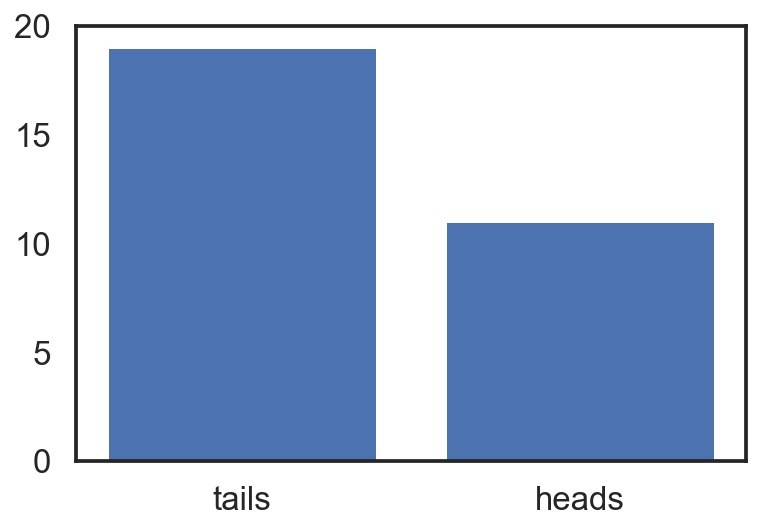

In [85]:
def plot_coins():
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.bar(list(Counter(tosses).keys()), list(Counter(tosses).values()))
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['tails', 'heads'])
    ax.set_ylim(0, 20)
    ax.set_yticks(np.arange(0, 21, 5))
    return fig
fig = plot_coins()
plt.show() 

**Quesion:** Is this a fair coin (50% of chance generating heads)?

In [86]:
# Step 2. Parameterize your problem using statistical distributions
# Step 3. Write model in PyMC3, and justify your model structure

# Context manager syntax. `coin_model` is **just** 
# a placeholder
with pm.Model() as coin_model: 
    # Distributions are PyMC3 objects.
    # Specify prior using Uniform object.
    p_prior = pm.Uniform('p', 0, 1)
    
    # Specify likelihood using Bernoulli object.
    like = pm.Bernoulli('likelihood', p=p_prior, 
                        observed=tosses)  
                        # "observed=data" is key
                        # for likelihood.

**Question:**  
Why not using Binomial distribution for the likelihood function?  

In [87]:
# Step 4. Hit the Inference Button

with coin_model:
    # don't worry about this:
    step = pm.Metropolis()
    
    # focus on this, the Inference Button:
    coin_trace = pm.sample(2000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.
The number of effective samples is smaller than 25% for some parameters.


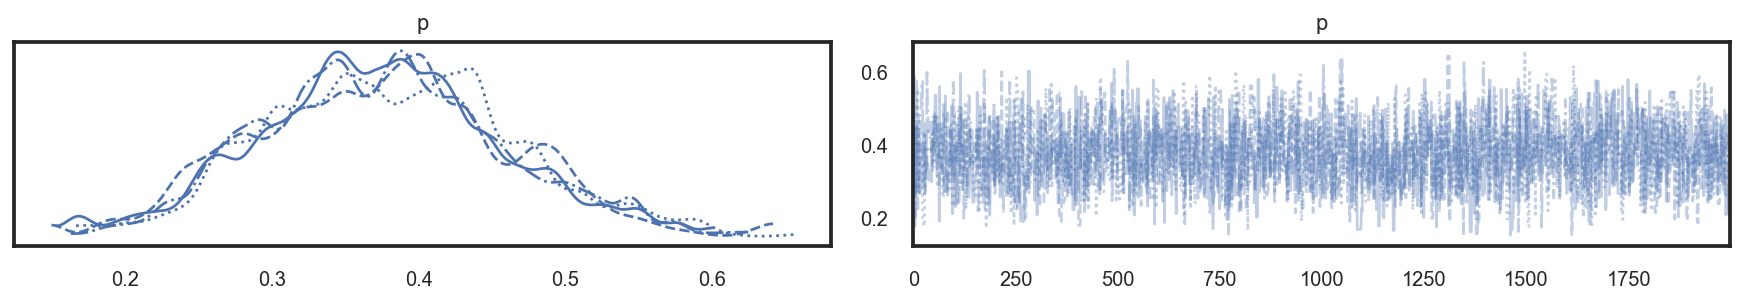

In [88]:
# Step 5. Interpret based on posterior distributions

pm.traceplot(coin_trace)
plt.show()

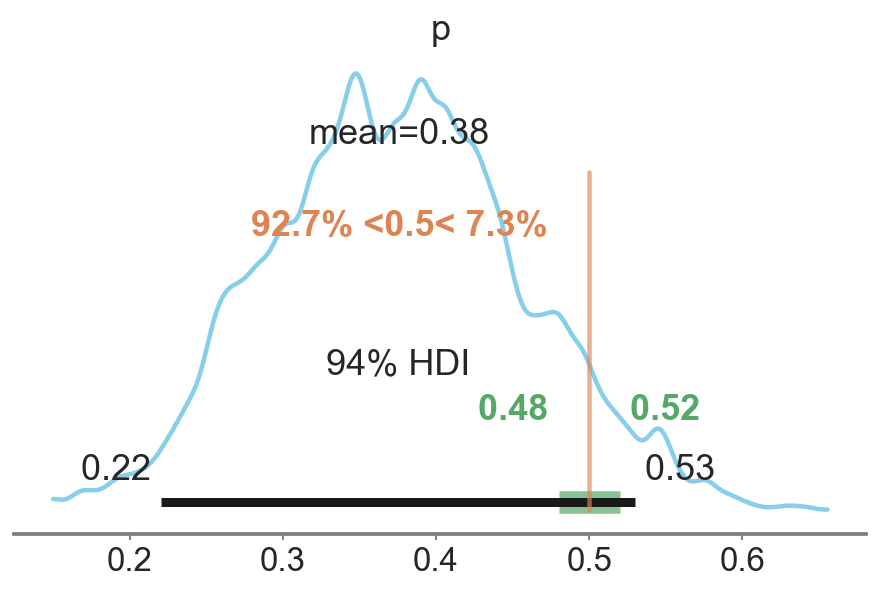

In [89]:
pm.plot_posterior(coin_trace[100:], color='#87ceeb', 
                  rope=[0.48, 0.52], point_estimate='mean', 
                  ref_val=0.5)
plt.show()

In [90]:
pm.summary(coin_trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
p  0.376  0.083    0.22     0.53      0.002    0.001    1977.0  1977.0   

   ess_bulk  ess_tail  r_hat  
p    1972.0    2049.0    1.0

- 95% highest posterior density (HPD) encompasses the region of practical equivalence (ROPE).
- What should we do? GET MORE DATA!


### Hands-on:
Modify the collected data as such: we have 60 tosses in total, and 22 of them are head. And then run all the cells again and see the results.

## 3.2 PyMC3 and Parameter Estimation <a id='32'>

![bayes](../images/pymc3_logo.jpg)

- Library of statistical distributions, sampling algorithms, and syntax for specifying statistical models
- Everything in Python!

### Common statistical analysis problems

- Parameter estimation: "is the true value equal to X?"
- Comparison between experimental groups: "are the treatments different from the control(s)?" "is design A better than design B?"

### Problem type 1: parameter estimation
"is the true value equal to X?"

OR

"given the data, for the parameter of interest, what is the probability distribution over the possible values?"  

### Example 2: Estimate the Proportion of Water

#### How much of a planet is covered in water?
Good news: you're an astronomer that just discovered a new planet. Bad news: your telescope has a small field of view and you can only see one tiny point on the planet at a time. More bad news: you're also a starving grad student and you can only take 5 measurements on your monthly stipend.

**With 5 measurements what is your estimate for how much of the planet is covered in water?**

In [91]:
# Step 1. collecting data 

observations = [0,0,0,1,1]
water_observations = sum(observations)
total_observations = len(observations)

Do you think the water coverage reaches 70% with 5 measurements?

In [92]:
# Step 2. Parameterize your problem using statistical distributions
# Step 3. Write model in PyMC3, and justify your model structure

with pm.Model() as planet_model: 
    # Distributions are PyMC3 objects.
    # Specify prior using Uniform object.
    p_prior = pm.Uniform('p', 0, 1) 
    
    # Specify likelihood using Binomial object.
    like = pm.Binomial('x', p=p_prior, 
                        n=total_observations, 
                        observed=water_observations)  

**Quesion:** Why don't we use Bernoulli distribution this time?

In [93]:
# Step 4. Hit the Inference Button

with planet_model:
    # don't worry about this:
    step = pm.Metropolis()
    
    # focus on this, the Inference Button:
    water_5obs_trace = pm.sample(2000, step=step, cores=2)

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [p]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 6 seconds.
The number of effective samples is smaller than 25% for some parameters.


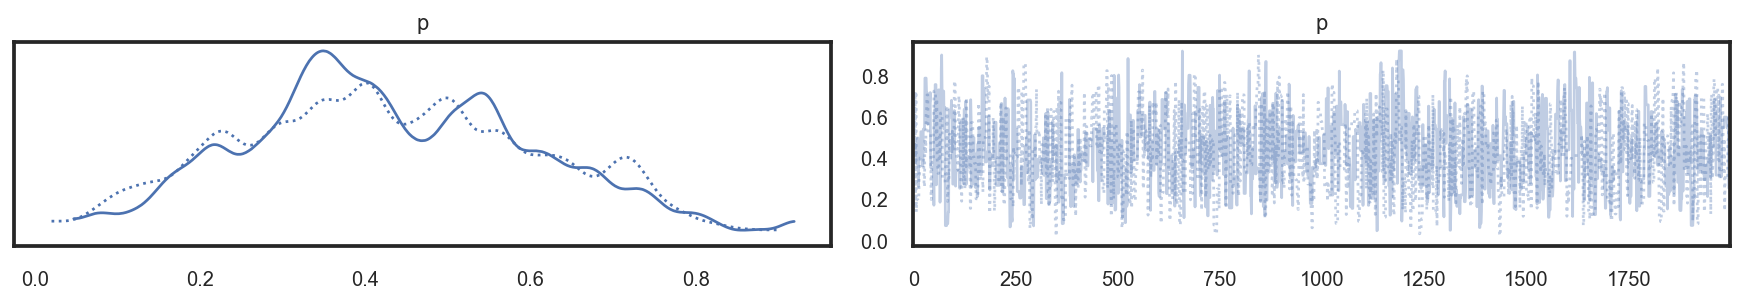

In [94]:
pm.traceplot(water_5obs_trace)
plt.show()

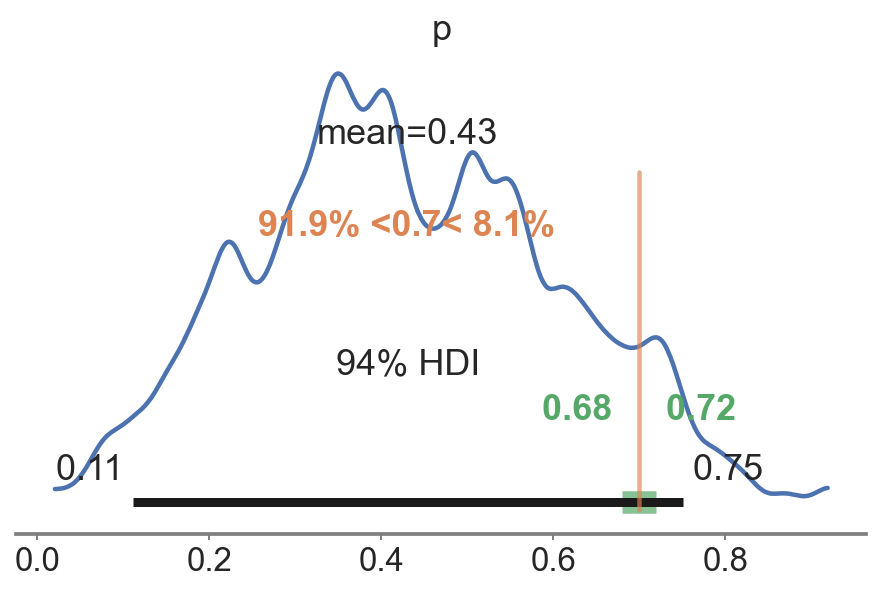

In [95]:
pm.plot_posterior(water_5obs_trace,
                  rope=[0.68, 0.72], point_estimate='mean', 
                  ref_val=0.7)

**Convert your inference data to az.InferenceData** using the methods az.from_pymc3 or az.from_stan. Then try a couple plots such as

- az.plot_trace
- az.plot_autocorr
- az.plot_forest

Try running a summary function such as

- az.summary

You can read more cool functions here: https://arviz-devs.github.io/arviz/

In [96]:
inference_data = az.from_pymc3(water_5obs_trace)
az.summary(inference_data)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
p  0.43  0.178   0.112    0.751      0.006    0.004     950.0   937.0   

   ess_bulk  ess_tail  r_hat  
p     939.0     960.0    1.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b934710>,
      dtype=object)

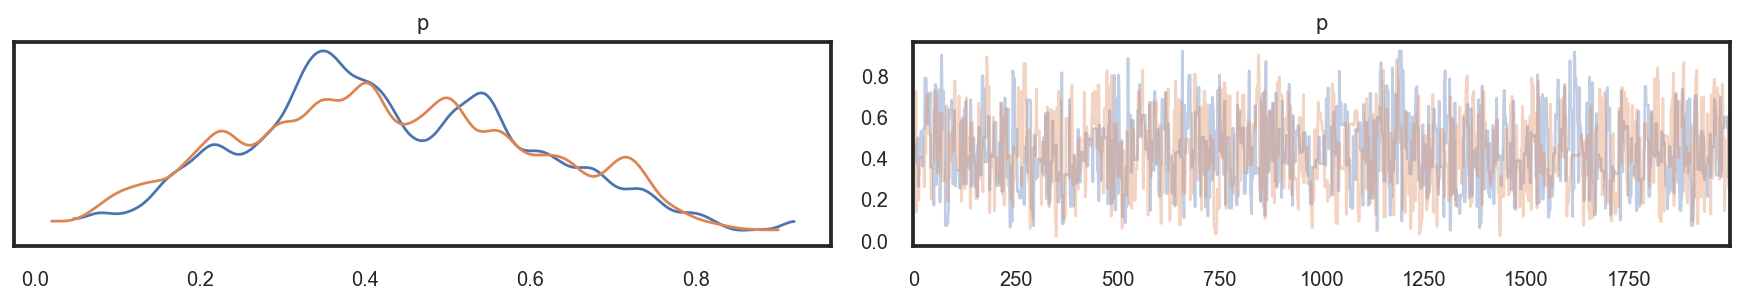

In [97]:
az.plot_trace(inference_data)

### Example 3: Completion time of a visual search task

Visual search is a type of perceptual task requiring attention that typically involves an active scan of the visual environment for a particular object or feature (the target) among other objects or features (the distractors). Visual search can take place with or without eye movements. The ability to consciously locate an object or target amongst a complex array of stimuli has been extensively studied over the past 40 years. Practical examples of using visual search can be seen in everyday life, such as when one is picking out a product on a supermarket shelf, when animals are searching for food among piles of leaves, when trying to find a friend in a large crowd of people, or simply when playing visual search games such as **Where's Wally?**

![visual_search](../images/visual_search.png)

Image from _A User Study of Visual Search Performance with Interactive 2D and 3D
Storyboards (Schoeffmann et al.)_

mean =  18.359795041833255
STD =  7.820730054587224


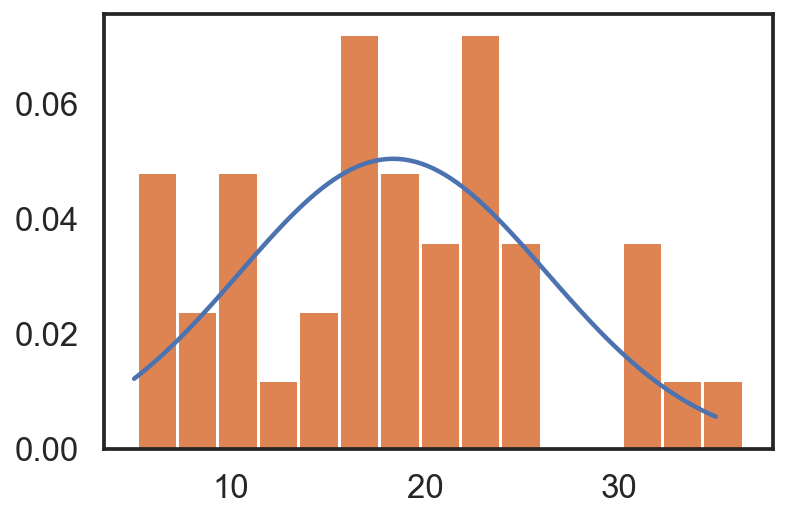

In [98]:
# Step 1. collecting data (pretend we have it)

np.random.seed(15)

completion_time = np.random.normal(20,8,40)
mu = np.mean(completion_time)
sigma = np.std(completion_time)
print ("mean = ", mu)
print ("STD = ",sigma)

x_s = np.linspace(5, 35, 100)
plt.plot(x_s, st.norm.pdf(x_s, completion_time.mean(), completion_time.std(ddof=1)))
plt.hist(completion_time,bins=15, density=True)
plt.show()

In [99]:
# Step 2. Parameterize your problem using statistical distributions
# Step 3. Write model in PyMC3, and justify your model structure

with pm.Model() as visual_search: 
    # Distributions are PyMC3 objects.
    # Specify prior using Uniform object.
    p_prior = pm.Uniform('p', 0, 40) 
    
    # Specify likelihood using Normal object.
    like = pm.Normal('x', mu=p_prior, 
                        observed=completion_time)  
                        # "observed=data" is key
                        # for likelihood.

In [100]:
# Step 4. Hit the Inference Button

with visual_search:
    # don't worry about this:
    step = pm.Metropolis()
    
    # focus on this, the Inference Button:
    visual_search_trace = pm.sample(20000, step=step,cores=2)

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [p]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 12 seconds.
The number of effective samples is smaller than 25% for some parameters.


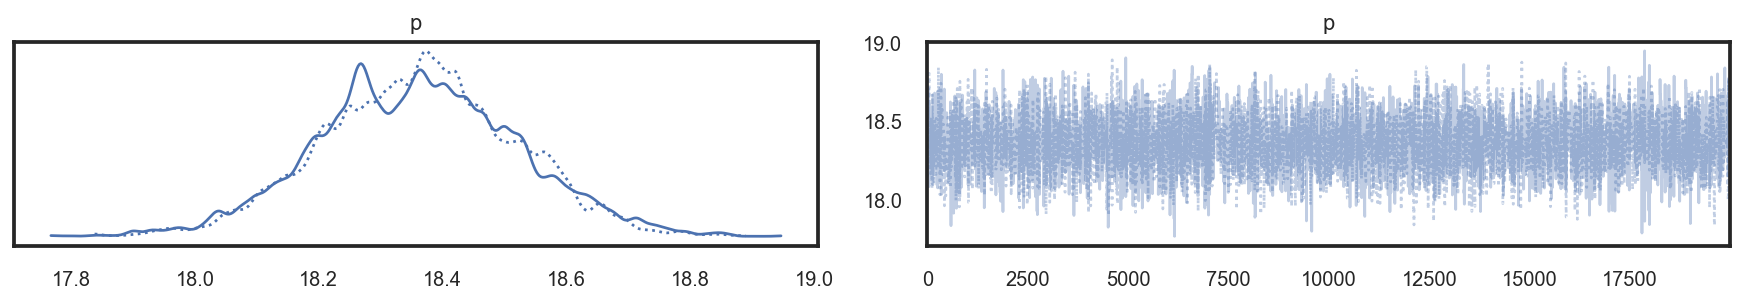

In [101]:
# Step 5. Interpret based on posterior distributions

pm.traceplot(visual_search_trace)
plt.show()

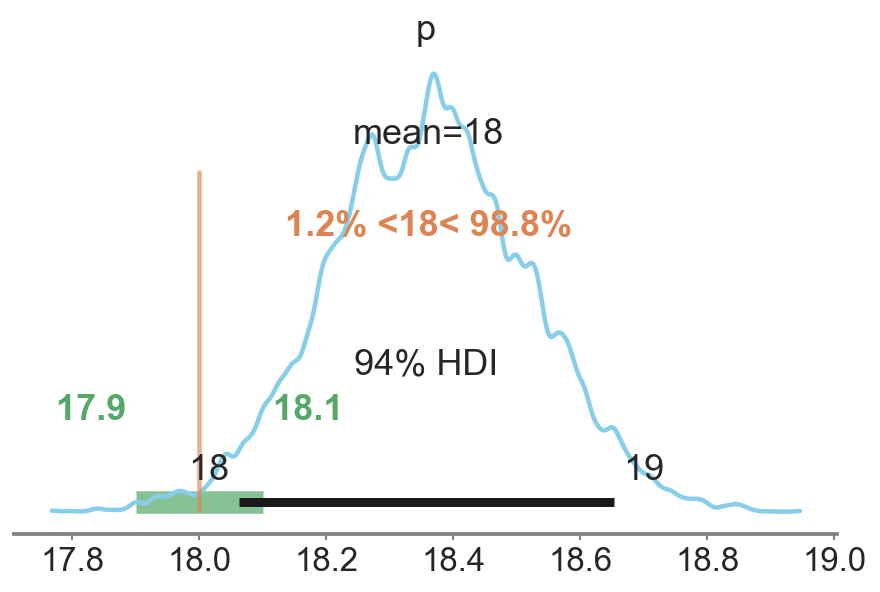

In [102]:
pm.plot_posterior(visual_search_trace, 
                  color='#87ceeb', point_estimate='mean', 
                  rope=[17.9, 18.1], ref_val=18)
plt.show()

In [103]:
pm.summary(visual_search_trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
p  18.36  0.158  18.062   18.653      0.002    0.002    4260.0  4256.0   

   ess_bulk  ess_tail  r_hat  
p    4266.0    4243.0    1.0

## 3.3  Comparison between A/B groups <a id="33">

"are my experimental treatments different from my controls?"  
(Which is typically done by Student t-test in frequentist's analysis)

### Example: The drug IQ problem

does a drug treatment affect IQ scores?

(documented in Kruschke, 2013, example from [PyMC3 documentation](https://docs.pymc.io/notebooks/BEST.html))

In [104]:
# Step 1. collecting data 

drug = [  99.,  110.,  107.,  104.,  103.,  105.,  105.,  110.,   99.,
        109.,  100.,  102.,  104.,  104.,  100.,  104.,  101.,  104.,
        101.,  100.,  109.,  104.,  105.,  112.,   97.,  106.,  103.,
        101.,  101.,  104.,   96.,  102.,  101.,  100.,   92.,  108.,
         97.,  106.,   96.,   90.,  109.,  108.,  105.,  104.,  110.,
         92.,  100.]

placebo = [  95.,  105.,  103.,   99.,  104.,   98.,  103.,  104.,  102.,
         91.,   97.,  101.,  100.,  113.,   98.,  102.,  100.,  105.,
         97.,   94.,  104.,   92.,   98.,  105.,  106.,  101.,  106.,
        105.,  101.,  105.,  102.,   95.,   91.,   99.,   96.,  102.,
         94.,   93.,   99.,   99.,  113.,   96.]

def ECDF(data):
    x = np.sort(data)
    y = np.cumsum(x) / np.sum(x)
    
    return x, y

def plot_drug():
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    x_drug, y_drug = ECDF(drug)
    ax.plot(x_drug, y_drug, label='drug, n={0}'.format(len(drug)))
    x_placebo, y_placebo = ECDF(placebo)
    ax.plot(x_placebo, y_placebo, label='placebo, n={0}'.format(len(placebo)))
    ax.legend()
    ax.set_xlabel('IQ Score')
    ax.set_ylabel('Cumulative Frequency')
    ax.hlines(0.5, ax.get_xlim()[0], ax.get_xlim()[1], linestyle='--')
    
    return fig

In [105]:
# From a frequentist point of view, is there a "statistically significant" difference
# between the two treatments?

from scipy.stats import ttest_ind

ttest_ind(drug, placebo)

Ttest_indResult(statistic=2.280670163432955, pvalue=0.025011500508647616)

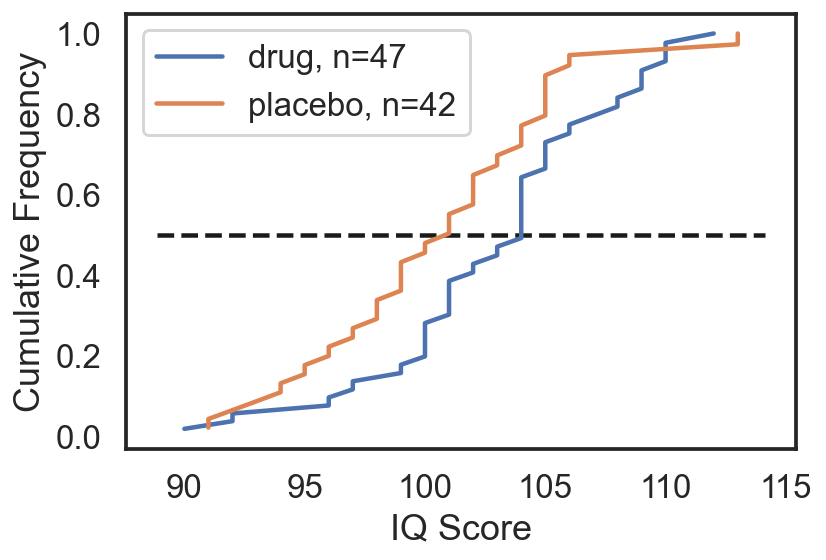

In [106]:
fig = plot_drug()
plt.show()

In [107]:
y_vals = np.concatenate([drug, placebo])
labels = ['drug'] * len(drug) + ['placebo'] * len(placebo)

data = pd.DataFrame([y_vals, labels]).T
data.columns = ['IQ', 'treatment']

![kruschke](../images/kruschke_model.png)

In [108]:
# Step 2. Parameterize your problem using statistical distributions
# Step 3. Write model in PyMC3, and justify your model structure

with pm.Model() as kruschke_model:
    # Focus on the use of Distribution Objects.
    # Linking Distribution Objects together is done by 
    # passing objects into other objects' parameters.
    mu_drug = pm.Normal('mu_drug', mu=0, sd=100**2)
    mu_placebo = pm.Normal('mu_placebo', mu=0, sd=100**2)
    sigma_drug = pm.HalfCauchy('sigma_drug', beta=100)
    sigma_placebo = pm.HalfCauchy('sigma_placebo', beta=100)
    nu = pm.Exponential('nu', lam=1/29) + 1
    
    drug_like = pm.StudentT('drug', nu=nu, mu=mu_drug, 
                            sd=sigma_drug, observed=drug)
    placebo_like = pm.StudentT('placebo', nu=nu, mu=mu_placebo, 
                               sd=sigma_placebo, observed=placebo)
    diff_means = pm.Deterministic('diff_means', mu_drug - mu_placebo)
    pooled_sd = pm.Deterministic('pooled_sd', 
                                 np.sqrt(np.power(sigma_drug, 2) + 
                                         np.power(sigma_placebo, 2) / 2))
    effect_size = pm.Deterministic('effect_size', 
                                   diff_means / pooled_sd)

In [109]:
with kruschke_model:
    kruschke_trace = pm.sample(10000, step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [nu]
>Metropolis: [sigma_placebo]
>Metropolis: [sigma_drug]
>Metropolis: [mu_placebo]
>Metropolis: [mu_drug]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 31 seconds.
The number of effective samples is smaller than 25% for some parameters.


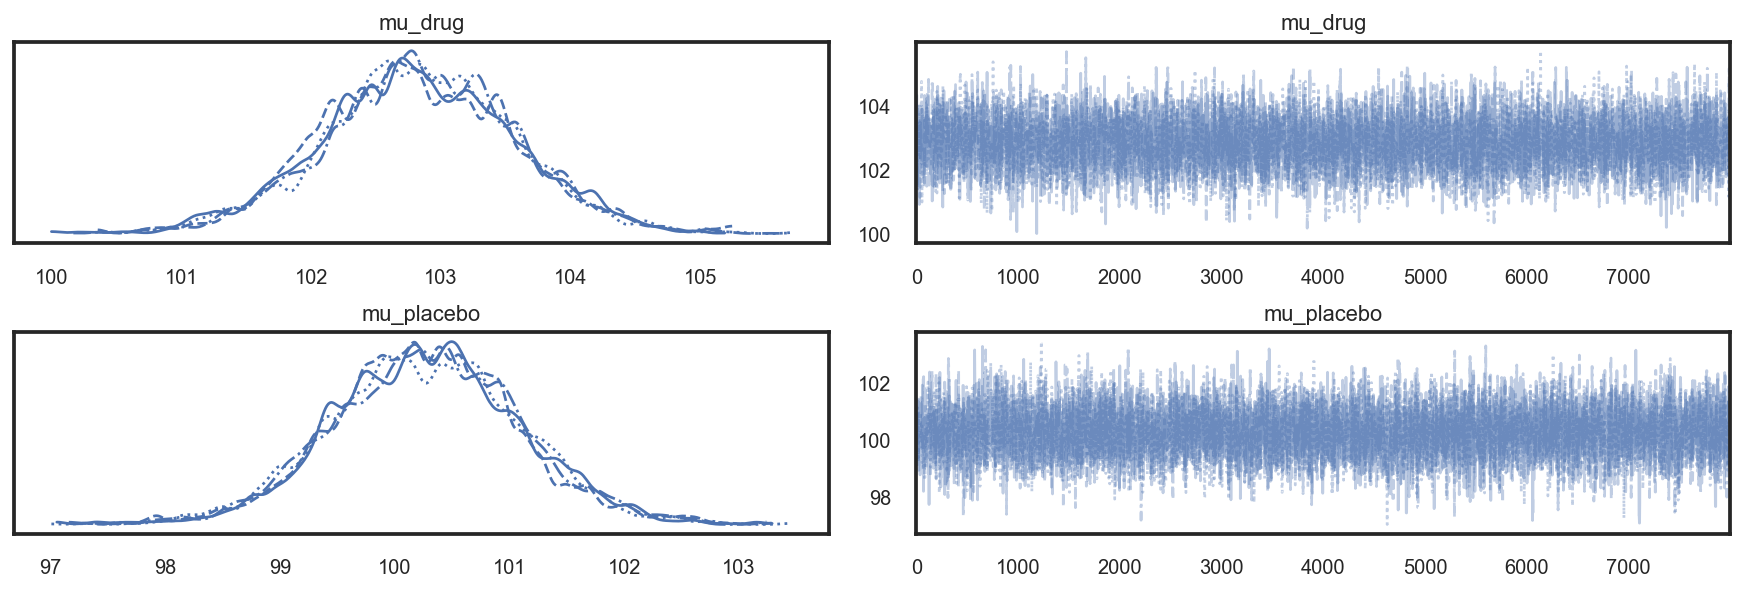

In [110]:
pm.traceplot(kruschke_trace[2000:], 
             varnames=['mu_drug', 'mu_placebo'])
plt.show()

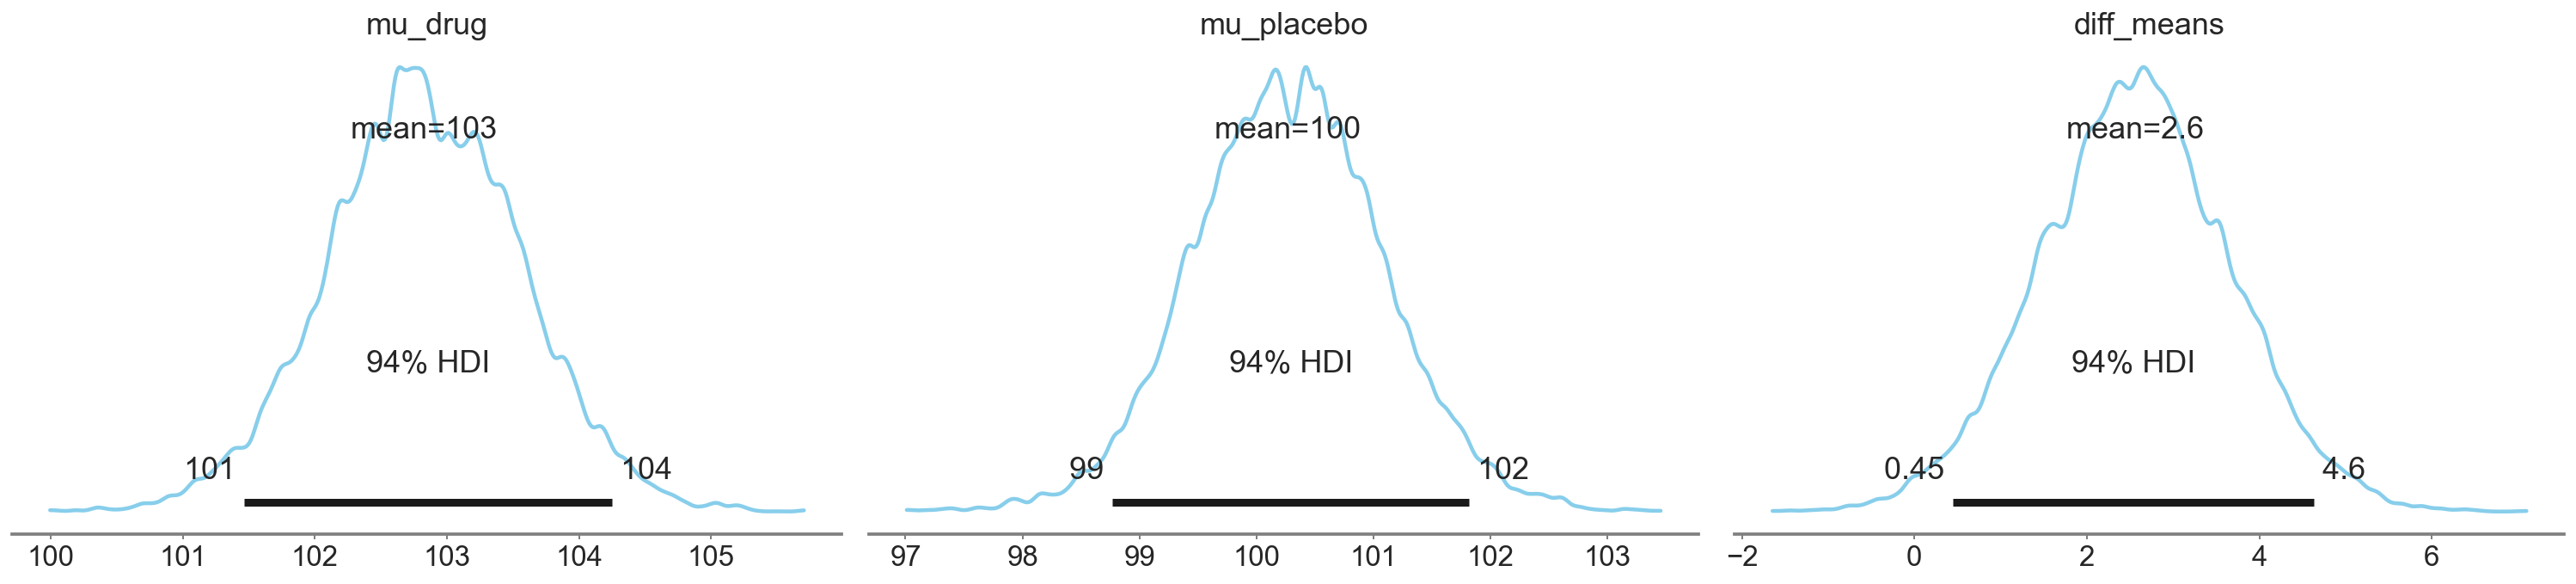

In [111]:
pm.plot_posterior(kruschke_trace[2000:], color='#87ceeb',
            varnames=['mu_drug', 'mu_placebo', 'diff_means'])
plt.show()

In [112]:
def get_forestplot_line(ax, kind):
    widths = {'median': 2.8, 'iqr': 2.0, 'hpd': 1.0}
    assert kind in widths.keys(), f'line kind must be one of {widths.keys()}'
    lines = []
    for child in ax.get_children():
        if isinstance(child, mpl.lines.Line2D) and np.allclose(child.get_lw(), widths[kind]):
            lines.append(child)
    return lines

def adjust_forestplot_for_slides(ax):    
    for line in get_forestplot_line(ax, kind='median'):
        line.set_markersize(10)

    for line in get_forestplot_line(ax, kind='iqr'):
        line.set_linewidth(5)

    for line in get_forestplot_line(ax, kind='hpd'):
        line.set_linewidth(3)
        
    return ax

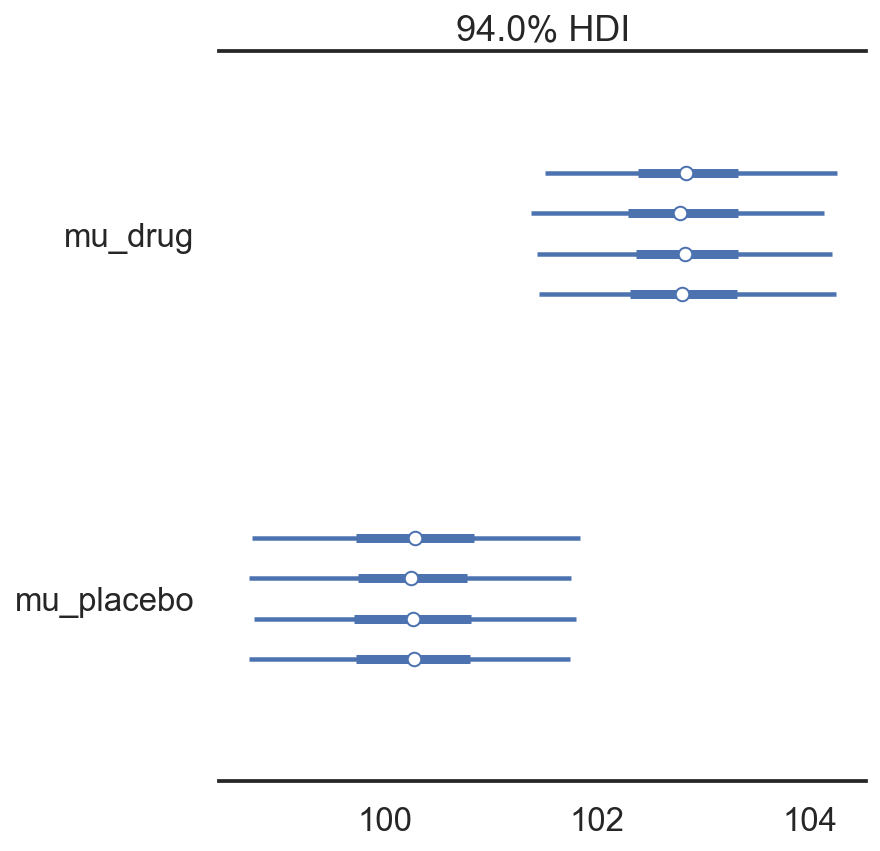

In [113]:
pm.forestplot(kruschke_trace[2000:], 
          varnames=['mu_drug', 'mu_placebo'])
ax = plt.gca()
ax = adjust_forestplot_for_slides(ax)
plt.show()

Forest plot: 95% HPD (thin line), IQR (thicker line), and median (dot) of the posterior distribution on the same axes, allowing us to directly compare the treatment and control.



In [114]:
def overlay_effect_size(ax):
    height = ax.get_ylim()[1] * 0.5
    ax.hlines(height, 0, 0.2, 'red', lw=5)
    ax.hlines(height, 0.2, 0.8, 'blue', lw=5)
    ax.hlines(height, 0.8, ax.get_xlim()[1], 'green', lw=5)

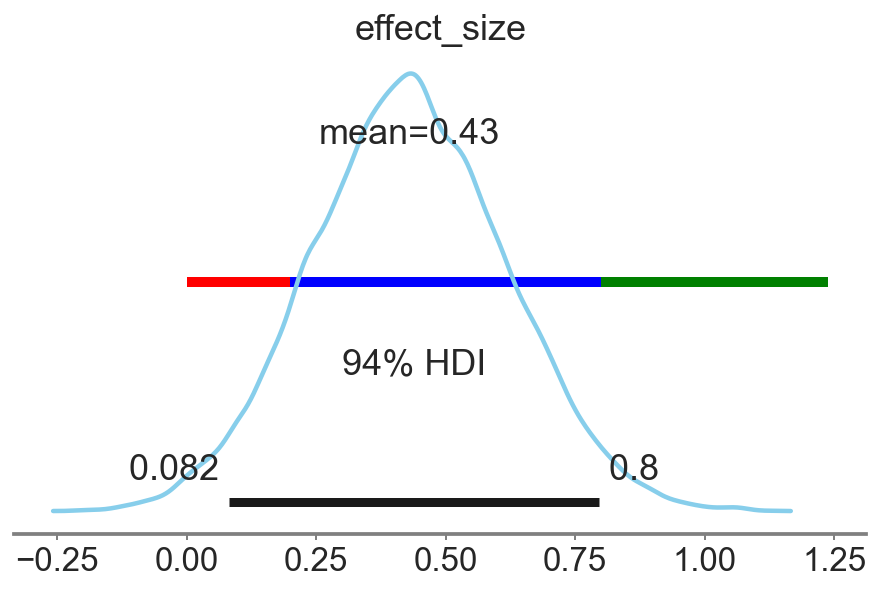

In [115]:
ax = pm.plot_posterior(kruschke_trace[2000:], 
                       varnames=['effect_size'],
                       color='#87ceeb')
overlay_effect_size(ax)

- Effect size (Cohen's d, none to small, medium, large) could be anywhere from essentially nothing to large (95% HPD [0.0, 0.77]).
- The drug is likely inconsequential.

For more examples of PyMC3, please refer to the [official document](https://docs.pymc.io/notebooks/getting_started.html).

<a href="#outline">Going back to outline</a>

-----

# Recap what we've learned today: <a id="summary">

## Part 0: Frequentist vs Baysian
- The fundamental differences between frequentist and Bayesian
- The limitation of frequentists' analysis  
- Probability as credibility points assigned in a region

## Part 1: Probability simulation
- Generating data using probability distribution (model) and MCMC sampling
- Know the basic distributions

## Part 2: Bayes' Theorem and Bayesian Inference
- Conditional probability
- Bayes' theorem
- Bayesian inference

## Part 3: Bayesian statistical analysis 
- Basic steps of doing Bayesian statistical analysis
- Problem type #1: parameter estimation 
- Problem type #2: comparing A/B groups

----
# Takeaway: 
### Basic steps of Bayesian Statistical Analysis

1. Collect data
2. Parameterize your problem using statistical distributions
3. Write model in PyMC3, and justify your model structure
4. Hit the Inference Button
5. Interpret based on posterior distributions
6. (optional) with new information, modify model structure.


![summary](../images/summary.png)

<div class="alert alert-block alert-danger">
<h2><img src="../images/warning.png" width="20", align="left">&nbsp;Warning</h2>
    <br>Note: PyMC3 is a great tool that does the math for lazy programmers. You can also easily find a bunch of instructions and tutorials of using PyMC3. However, this lecture does not simply want you know how to repeat the same steps only, but clearly know the foundation of Bayesian statistics.
    <br><br>
Lastly, feel free to ping me for any question about this notebook or the assignment.<br>
My email: yi-chi.liao@aalto.fi
</div>

<a href="#outline">Going back to outline</a>